In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
(224, 224)
42
1_2_3


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5364 - accuracy: 0.6408 - precision: 0.9346 - recall: 0.6129 - f1: 0.7310 - specificity: 0.8130 - negative_predictive_value: 0.2668 - matthews_correlation_coefficient: 0.2993 - val_loss: 0.5579 - val_accuracy: 0.6323 - val_precision: 0.9685 - val_recall: 0.6012 - val_f1: 0.7347 - val_specificity: 0.8686 - val_negative_predictive_value: 0.2667 - val_matthews_correlation_coefficient: 0.3250

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.32498, saving model to ../models/autoencoders_requirements/blurred_2020_03_27-23_49_46.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4969 - accuracy: 0.6618 - precision: 0.9558 - recall: 0.6277 - f1: 0.7504 - specificity: 0.8273 - negative_predictive_value: 0.2843 - matthews_correlation_coefficient: 0.3336 - val_loss: 0.4887 - val_accuracy: 0.7095 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.41669
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4437 - accuracy: 0.7377 - precision: 0.9613 - recall: 0.7250 - f1: 0.8213 - specificity: 0.8154 - negative_predictive_value: 0.3358 - matthews_correlation_coefficient: 0.3956 - val_loss: 0.4143 - val_accuracy: 0.8049 - val_precision: 0.9488 - val_recall: 0.8221 - val_f1: 0.8791 - val_specificity: 0.7050 - val_negative_predictive_value: 0.3847 - val_matthews_correlation_coefficient: 0.4110

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.41669
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4381 - accuracy: 0.7453 - precision: 0.9643 - recall: 0.7291 - f1: 0.8249 - specificity: 0.8326 - negative_predictive_value: 0.3509 - matthews_correlation_coefficient: 0.4150 - val_loss: 0.4760 - val_accuracy: 0.7554 - val_precision: 0.9682 - val_recall: 0.7463 - val_f1: 0.8394 - val_spe

4610/4610 [==============================] - 10s 2ms/step - loss: 0.4497 - accuracy: 0.7534 - precision: 0.9582 - recall: 0.7359 - f1: 0.8250 - specificity: 0.8237 - negative_predictive_value: 0.3613 - matthews_correlation_coefficient: 0.4250 - val_loss: 0.5230 - val_accuracy: 0.7077 - val_precision: 0.9817 - val_recall: 0.6799 - val_f1: 0.7981 - val_specificity: 0.8916 - val_negative_predictive_value: 0.3127 - val_matthews_correlation_coefficient: 0.4023

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.44806
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4507 - accuracy: 0.7271 - precision: 0.9656 - recall: 0.7129 - f1: 0.8109 - specificity: 0.8274 - negative_predictive_value: 0.3425 - matthews_correlation_coefficient: 0.4010 - val_loss: 0.4149 - val_accuracy: 0.7971 - val_precision: 0.9568 - val_recall: 0.8042 - val_f1: 0.8716 - val_specificity: 0.7741 - val_negative_predictive_value: 0.3895 - val_matthews_correlation_coeffici

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3978 - accuracy: 0.7826 - precision: 0.9697 - recall: 0.7723 - f1: 0.8564 - specificity: 0.8365 - negative_predictive_value: 0.3784 - matthews_correlation_coefficient: 0.4533 - val_loss: 0.4370 - val_accuracy: 0.7485 - val_precision: 0.9778 - val_recall: 0.7309 - val_f1: 0.8314 - val_specificity: 0.8758 - val_negative_predictive_value: 0.3508 - val_matthews_correlation_coefficient: 0.4373

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.47827
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3971 - accuracy: 0.7766 - precision: 0.9732 - recall: 0.7640 - f1: 0.8518 - specificity: 0.8406 - negative_predictive_value: 0.3845 - matthews_correlation_coefficient: 0.4602 - val_loss: 0.4722 - val_accuracy: 0.7650 - val_precision: 0.9749 - val_recall: 0.7507 - val_f1: 0.8444 - val_specificity: 0.8665 - val_negative_predictive_value: 0.3629 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.48425
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3822 - accuracy: 0.7868 - precision: 0.9732 - recall: 0.7746 - f1: 0.8593 - specificity: 0.8620 - negative_predictive_value: 0.3921 - matthews_correlation_coefficient: 0.4755 - val_loss: 0.3842 - val_accuracy: 0.7832 - val_precision: 0.9623 - val_recall: 0.7838 - val_f1: 0.8605 - val_specificity: 0.7987 - val_negative_predictive_value: 0.3748 - val_matthews_correlation_coefficient: 0.4342

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.48425
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3846 - accuracy: 0.7879 - precision: 0.9720 - recall: 0.7766 - f1: 0.8595 - specificity: 0.8544 - negative_predictive_value: 0.3971 - matthews_correlation_coefficient: 0.4733 - val_loss: 0.4183 - val_accuracy: 0.7901 - val_precision: 0.9689 - val_recall: 0.7857 - val_f1: 0.8650 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.48490
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3822 - accuracy: 0.8026 - precision: 0.9738 - recall: 0.7924 - f1: 0.8702 - specificity: 0.8742 - negative_predictive_value: 0.4148 - matthews_correlation_coefficient: 0.5000 - val_loss: 0.3879 - val_accuracy: 0.8265 - val_precision: 0.9608 - val_recall: 0.8360 - val_f1: 0.8921 - val_specificity: 0.7770 - val_negative_predictive_value: 0.4375 - val_matthews_correlation_coefficient: 0.4845

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.48490
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3660 - accuracy: 0.8074 - precision: 0.9681 - recall: 0.8008 - f1: 0.8732 - specificity: 0.8445 - negative_predictive_value: 0.4116 - matthews_correlation_coefficient: 0.4890 - val_loss: 0.3428 - val_accuracy: 0.8257 - val_precision: 0.9535 - val_recall: 0.8416 - val_f1: 0.8915 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.48490
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3586 - accuracy: 0.8091 - precision: 0.9762 - recall: 0.7993 - f1: 0.8762 - specificity: 0.8775 - negative_predictive_value: 0.4337 - matthews_correlation_coefficient: 0.5200 - val_loss: 0.3557 - val_accuracy: 0.8326 - val_precision: 0.9603 - val_recall: 0.8442 - val_f1: 0.8964 - val_specificity: 0.7743 - val_negative_predictive_value: 0.4494 - val_matthews_correlation_coefficient: 0.4933

Epoch 00088: val_matthews_correlation_coefficient improved from 0.48490 to 0.49328, saving model to ../models/autoencoders_requirements/blurred_2020_03_27-23_49_46.h5
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3609 - accuracy: 0.8056 - precision: 0.9737 - recall: 0.7971 - f1: 0.8742 - specificity: 0.8639 - negative_predictive_value: 0.4183 - matthews_correlation_coefficient: 0.5019 - val_loss: 0.3309 - val_

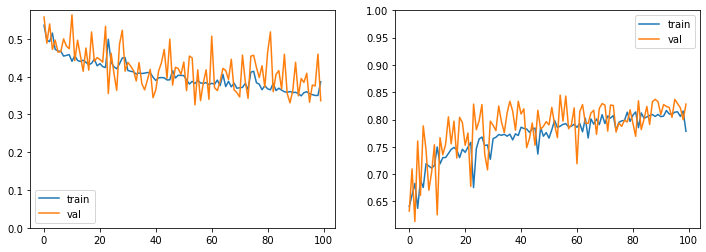

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6710 - accuracy: 0.5766 - precision: 0.7539 - recall: 0.5385 - f1: 0.6000 - specificity: 0.6416 - negative_predictive_value: 0.4121 - matthews_correlation_coefficient: 0.1837 - val_loss: 0.6522 - val_accuracy: 0.6522 - val_precision: 0.7353 - val_recall: 0.6904 - val_f1: 0.7089 - val_specificity: 0.5042 - val_negative_predictive_value: 0.4470 - val_matthews_correlation_coefficient: 0.2149

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21486, saving model to ../models/autoencoders_requirements/looking_away_2020_03_28-00_04_59.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6625 - accuracy: 0.6171 - precision: 0.7741 - recall: 0.6172 - f1: 0.6720 - specificity: 0.6119 - negative_predictive_value: 0.4410 - matthews_correlation_coefficient: 0.2210 - val_loss: 0.6579 - val_accuracy: 0.5932 - val_precisio

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6215 - accuracy: 0.6592 - precision: 0.8084 - recall: 0.6656 - f1: 0.7210 - specificity: 0.6542 - negative_predictive_value: 0.4823 - matthews_correlation_coefficient: 0.3041 - val_loss: 0.6010 - val_accuracy: 0.6713 - val_precision: 0.7931 - val_recall: 0.6372 - val_f1: 0.7032 - val_specificity: 0.6738 - val_negative_predictive_value: 0.4747 - val_matthews_correlation_coefficient: 0.3148

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.33602
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6173 - accuracy: 0.6570 - precision: 0.8159 - recall: 0.6464 - f1: 0.7089 - specificity: 0.6774 - negative_predictive_value: 0.4801 - matthews_correlation_coefficient: 0.3094 - val_loss: 0.5885 - val_accuracy: 0.6904 - val_precision: 0.7962 - val_recall: 0.6717 - val_f1: 0.7240 - val_specificity: 0.6561 - val_negative_predictive_value: 0.4956 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5810 - accuracy: 0.6905 - precision: 0.8222 - recall: 0.7026 - f1: 0.7505 - specificity: 0.6726 - negative_predictive_value: 0.5163 - matthews_correlation_coefficient: 0.3550 - val_loss: 0.5692 - val_accuracy: 0.7077 - val_precision: 0.8002 - val_recall: 0.6979 - val_f1: 0.7415 - val_specificity: 0.6586 - val_negative_predictive_value: 0.5195 - val_matthews_correlation_coefficient: 0.3635

Epoch 00028: val_matthews_correlation_coefficient improved from 0.35827 to 0.36349, saving model to ../models/autoencoders_requirements/looking_away_2020_03_28-00_04_59.h5
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5886 - accuracy: 0.6950 - precision: 0.8237 - recall: 0.7132 - f1: 0.7563 - specificity: 0.6688 - negative_predictive_value: 0.5314 - matthews_correlation_coefficient: 0.3668 - val_loss: 0.6268 - val_accuracy: 0.6592 - val_precision: 0.8155 - val_recall: 0.5934 - val_f1: 0.6825 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5645 - accuracy: 0.7033 - precision: 0.8254 - recall: 0.7137 - f1: 0.7570 - specificity: 0.6825 - negative_predictive_value: 0.5323 - matthews_correlation_coefficient: 0.3767 - val_loss: 0.5581 - val_accuracy: 0.7225 - val_precision: 0.8127 - val_recall: 0.7112 - val_f1: 0.7550 - val_specificity: 0.6761 - val_negative_predictive_value: 0.5358 - val_matthews_correlation_coefficient: 0.3934

Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.40181
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5621 - accuracy: 0.7061 - precision: 0.8338 - recall: 0.7010 - f1: 0.7553 - specificity: 0.7087 - negative_predictive_value: 0.5348 - matthews_correlation_coefficient: 0.3894 - val_loss: 0.6498 - val_accuracy: 0.6505 - val_precision: 0.8343 - val_recall: 0.5621 - val_f1: 0.6665 - val_specificity: 0.7738 - val_negative_predictive_value: 0.4556 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5496 - accuracy: 0.7128 - precision: 0.8478 - recall: 0.7116 - f1: 0.7677 - specificity: 0.7214 - negative_predictive_value: 0.5396 - matthews_correlation_coefficient: 0.4080 - val_loss: 0.5814 - val_accuracy: 0.6878 - val_precision: 0.8134 - val_recall: 0.6467 - val_f1: 0.7165 - val_specificity: 0.7049 - val_negative_predictive_value: 0.4939 - val_matthews_correlation_coefficient: 0.3546

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.40181
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5441 - accuracy: 0.7111 - precision: 0.8411 - recall: 0.7090 - f1: 0.7645 - specificity: 0.7072 - negative_predictive_value: 0.5328 - matthews_correlation_coefficient: 0.3950 - val_loss: 0.6191 - val_accuracy: 0.7034 - val_precision: 0.8220 - val_recall: 0.6635 - val_f1: 0.7309 - val_specificity: 0.7191 - val_negative_predictive_value: 0.5071 - val_matthews_correlation_coefficie

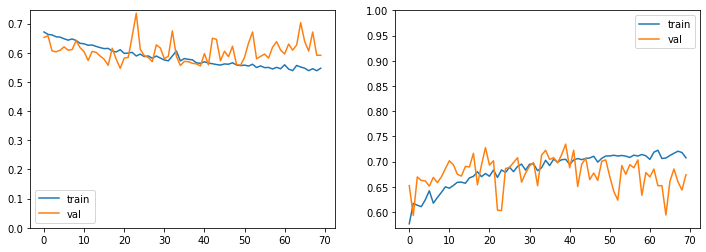

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

the requirement ink_marked_creased has only one label.


#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6564 - accuracy: 0.6067 - precision: 0.6110 - recall: 0.6075 - f1: 0.5815 - specificity: 0.6093 - negative_predictive_value: 0.5994 - matthews_correlation_coefficient: 0.2234 - val_loss: 0.6229 - val_accuracy: 0.6548 - val_precision: 0.6659 - val_recall: 0.6152 - val_f1: 0.6310 - val_specificity: 0.6613 - val_negative_predictive_value: 0.6179 - val_matthews_correlation_coefficient: 0.3070

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30700, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_28-00_15_32.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6128 - accuracy: 0.6755 - precision: 0.6829 - recall: 0.7377 - f1: 0.6930 - specificity: 0.6172 - negative_predictive_value: 0.6953 - matthews_correlation_coefficient: 0.3674 - val_loss: 0.6196 - val_accuracy: 0.6704 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5156 - accuracy: 0.7332 - precision: 0.7254 - recall: 0.8080 - f1: 0.7574 - specificity: 0.6610 - negative_predictive_value: 0.7612 - matthews_correlation_coefficient: 0.4773 - val_loss: 0.5334 - val_accuracy: 0.7242 - val_precision: 0.6948 - val_recall: 0.7661 - val_f1: 0.7229 - val_specificity: 0.6358 - val_negative_predictive_value: 0.7276 - val_matthews_correlation_coefficient: 0.4386

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.45946
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5172 - accuracy: 0.7375 - precision: 0.7220 - recall: 0.8185 - f1: 0.7614 - specificity: 0.6589 - negative_predictive_value: 0.7691 - matthews_correlation_coefficient: 0.4838 - val_loss: 0.5471 - val_accuracy: 0.7242 - val_precision: 0.7649 - val_recall: 0.6304 - val_f1: 0.6853 - val_specificity: 0.8116 - val_negative_predictive_value: 0.6879 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.48837
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4964 - accuracy: 0.7521 - precision: 0.7459 - recall: 0.8075 - f1: 0.7663 - specificity: 0.6925 - negative_predictive_value: 0.7684 - matthews_correlation_coefficient: 0.5085 - val_loss: 0.5041 - val_accuracy: 0.7624 - val_precision: 0.7396 - val_recall: 0.7863 - val_f1: 0.7568 - val_specificity: 0.7149 - val_negative_predictive_value: 0.7775 - val_matthews_correlation_coefficient: 0.5086

Epoch 00030: val_matthews_correlation_coefficient improved from 0.48837 to 0.50857, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_28-00_15_32.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4840 - accuracy: 0.7638 - precision: 0.7462 - recall: 0.8174 - f1: 0.7730 - specificity: 0.7020 - negative_predictive_value: 0.7845 - matthews_correlation_coefficient: 0.5247 - val_loss: 0


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.50857
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4685 - accuracy: 0.7651 - precision: 0.7594 - recall: 0.8127 - f1: 0.7767 - specificity: 0.7102 - negative_predictive_value: 0.7810 - matthews_correlation_coefficient: 0.5327 - val_loss: 0.5032 - val_accuracy: 0.7624 - val_precision: 0.7519 - val_recall: 0.7574 - val_f1: 0.7493 - val_specificity: 0.7503 - val_negative_predictive_value: 0.7623 - val_matthews_correlation_coefficient: 0.5108

Epoch 00045: val_matthews_correlation_coefficient improved from 0.50857 to 0.51076, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_28-00_15_32.h5
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4726 - accuracy: 0.7690 - precision: 0.7580 - recall: 0.8266 - f1: 0.7837 - specificity: 0.7128 - negative_predictive_value: 0.7969 - matthews_correlation_coefficient: 0.5466 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4770 - accuracy: 0.7692 - precision: 0.7723 - recall: 0.8122 - f1: 0.7813 - specificity: 0.7348 - negative_predictive_value: 0.7856 - matthews_correlation_coefficient: 0.5520 - val_loss: 0.4989 - val_accuracy: 0.7528 - val_precision: 0.7125 - val_recall: 0.8150 - val_f1: 0.7564 - val_specificity: 0.6398 - val_negative_predictive_value: 0.7657 - val_matthews_correlation_coefficient: 0.4930

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.52561
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4626 - accuracy: 0.7696 - precision: 0.7581 - recall: 0.8162 - f1: 0.7793 - specificity: 0.7073 - negative_predictive_value: 0.7848 - matthews_correlation_coefficient: 0.5345 - val_loss: 0.4993 - val_accuracy: 0.7606 - val_precision: 0.7314 - val_recall: 0.7911 - val_f1: 0.7559 - val_specificity: 0.7055 - val_negative_predictive_value: 0.7804 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4569 - accuracy: 0.7774 - precision: 0.7733 - recall: 0.8196 - f1: 0.7893 - specificity: 0.7373 - negative_predictive_value: 0.7937 - matthews_correlation_coefficient: 0.5617 - val_loss: 0.5011 - val_accuracy: 0.7641 - val_precision: 0.7556 - val_recall: 0.7486 - val_f1: 0.7474 - val_specificity: 0.7572 - val_negative_predictive_value: 0.7579 - val_matthews_correlation_coefficient: 0.5095

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.52561
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4574 - accuracy: 0.7748 - precision: 0.7628 - recall: 0.8141 - f1: 0.7801 - specificity: 0.7264 - negative_predictive_value: 0.7907 - matthews_correlation_coefficient: 0.5483 - val_loss: 0.4995 - val_accuracy: 0.7563 - val_precision: 0.7413 - val_recall: 0.7609 - val_f1: 0.7470 - val_specificity: 0.7312 - val_negative_predictive_value: 0.7567 - val_matthews_correlation_coefficie

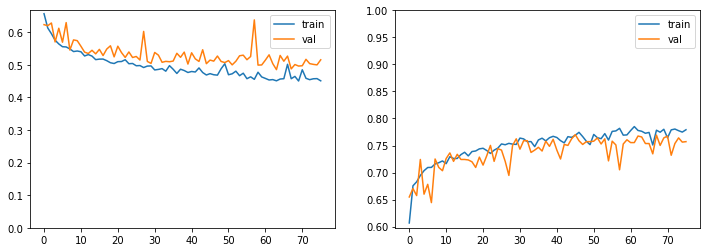

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6029 - accuracy: 0.6351 - precision: 0.9598 - recall: 0.6288 - f1: 0.7110 - specificity: 0.6806 - negative_predictive_value: 0.1945 - matthews_correlation_coefficient: 0.2287 - val_loss: 0.4437 - val_accuracy: 0.8283 - val_precision: 0.9704 - val_recall: 0.8438 - val_f1: 0.9011 - val_specificity: 0.6113 - val_negative_predictive_value: 0.2674 - val_matthews_correlation_coefficient: 0.3265

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.32652, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_28-00_26_55.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4746 - accuracy: 0.7753 - precision: 0.9786 - recall: 0.7756 - f1: 0.8591 - specificity: 0.7131 - negative_predictive_value: 0.2701 - matthews_correlation_coefficient: 0.3478 - val_loss: 0.2619 - val_accuracy: 0.9037 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3781 - accuracy: 0.8388 - precision: 0.9842 - recall: 0.8408 - f1: 0.9041 - specificity: 0.8005 - negative_predictive_value: 0.3314 - matthews_correlation_coefficient: 0.4367 - val_loss: 0.3723 - val_accuracy: 0.8578 - val_precision: 0.9897 - val_recall: 0.8594 - val_f1: 0.9184 - val_specificity: 0.8009 - val_negative_predictive_value: 0.3445 - val_matthews_correlation_coefficient: 0.4588

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.50216
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3565 - accuracy: 0.8623 - precision: 0.9834 - recall: 0.8670 - f1: 0.9195 - specificity: 0.7626 - negative_predictive_value: 0.3589 - matthews_correlation_coefficient: 0.4553 - val_loss: 0.3021 - val_accuracy: 0.8855 - val_precision: 0.9881 - val_recall: 0.8903 - val_f1: 0.9355 - val_specificity: 0.7671 - val_negative_predictive_value: 0.3829 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3086 - accuracy: 0.8688 - precision: 0.9878 - recall: 0.8690 - f1: 0.9229 - specificity: 0.8059 - negative_predictive_value: 0.3745 - matthews_correlation_coefficient: 0.4863 - val_loss: 0.2719 - val_accuracy: 0.8864 - val_precision: 0.9869 - val_recall: 0.8920 - val_f1: 0.9359 - val_specificity: 0.7626 - val_negative_predictive_value: 0.3896 - val_matthews_correlation_coefficient: 0.4890

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.50216
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3265 - accuracy: 0.8668 - precision: 0.9860 - recall: 0.8692 - f1: 0.9222 - specificity: 0.7635 - negative_predictive_value: 0.3621 - matthews_correlation_coefficient: 0.4600 - val_loss: 0.3049 - val_accuracy: 0.8794 - val_precision: 0.9878 - val_recall: 0.8836 - val_f1: 0.9319 - val_specificity: 0.7896 - val_negative_predictive_value: 0.3777 - val_matthews_correlation_coefficie

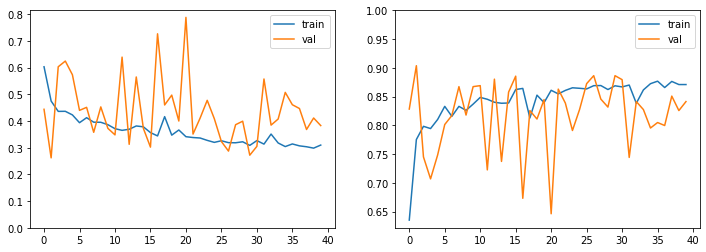

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5688 - accuracy: 0.7976 - precision: 0.9961 - recall: 0.8010 - f1: 0.8817 - specificity: 0.1310 - negative_predictive_value: 0.0228 - matthews_correlation_coefficient: 0.0428 - val_loss: 0.3959 - val_accuracy: 0.7294 - val_precision: 0.9730 - val_recall: 0.7078 - val_f1: 0.8175 - val_specificity: 0.2162 - val_negative_predictive_value: 0.0266 - val_matthews_correlation_coefficient: 0.0628

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06277, saving model to ../models/autoencoders_requirements/washed_out_2020_03_28-00_32_56.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4304 - accuracy: 0.7416 - precision: 0.9989 - recall: 0.7419 - f1: 0.8416 - specificity: 0.2034 - negative_predictive_value: 0.0489 - matthews_correlation_coefficient: 0.0775 - val_loss: 0.1033 - val_accuracy: 0.9879 - val_precision:


Epoch 00014: val_matthews_correlation_coefficient improved from 0.19605 to 0.19976, saving model to ../models/autoencoders_requirements/washed_out_2020_03_28-00_32_56.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3128 - accuracy: 0.9085 - precision: 0.9994 - recall: 0.9058 - f1: 0.9450 - specificity: 0.2207 - negative_predictive_value: 0.1174 - matthews_correlation_coefficient: 0.1461 - val_loss: 0.1580 - val_accuracy: 0.9514 - val_precision: 0.9721 - val_recall: 0.9271 - val_f1: 0.9488 - val_specificity: 0.2027 - val_negative_predictive_value: 0.1104 - val_matthews_correlation_coefficient: 0.1428

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.19976
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0935 - accuracy: 0.9670 - precision: 0.9998 - recall: 0.9640 - f1: 0.9799 - specificity: 0.2552 - negative_predictive_value: 0.1972 - matthews_correlation_coefficient: 0.2154 - val_loss: 0.2565 - v


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.19976
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0620 - accuracy: 0.9729 - precision: 0.9998 - recall: 0.9731 - f1: 0.9859 - specificity: 0.2414 - negative_predictive_value: 0.1708 - matthews_correlation_coefficient: 0.1956 - val_loss: 0.0267 - val_accuracy: 0.9913 - val_precision: 0.9991 - val_recall: 0.9924 - val_f1: 0.9956 - val_specificity: 0.2027 - val_negative_predictive_value: 0.2027 - val_matthews_correlation_coefficient: 0.1998

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.19976
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0794 - accuracy: 0.9625 - precision: 0.9998 - recall: 0.9625 - f1: 0.9798 - specificity: 0.2172 - negative_predictive_value: 0.1582 - matthews_correlation_coefficient: 0.1757 - val_loss: 0.0436 - val_accuracy: 0.9835 - val_precision: 0.9991 - val_recall: 0.9847 - val_f1: 0.9918 - val_spe

Restoring model weights from the end of the best epoch

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.19976
Epoch 00044: early stopping

   Final Accuracy:  99.05%
  Final Precision:  99.91%
     Final Recall:  99.13%
  Final F-measure:  99.52%
Final Specificity:  90.00%
        Final NPV:  47.37%
        Final MCC:  64.91%
[[   9    1]
 [  10 1133]]
              precision    recall  f1-score   support

           0       0.47      0.90      0.62        10
           1       1.00      0.99      1.00      1143

    accuracy                           0.99      1153
   macro avg       0.74      0.95      0.81      1153
weighted avg       0.99      0.99      0.99      1153



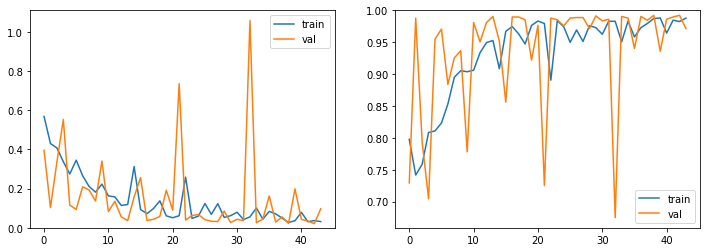

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6597 - accuracy: 0.5924 - precision: 0.9554 - recall: 0.5895 - f1: 0.7086 - specificity: 0.5679 - negative_predictive_value: 0.1166 - matthews_correlation_coefficient: 0.1210 - val_loss: 0.7086 - val_accuracy: 0.5082 - val_precision: 0.9437 - val_recall: 0.4742 - val_f1: 0.6252 - val_specificity: 0.7288 - val_negative_predictive_value: 0.1293 - val_matthews_correlation_coefficient: 0.1329

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.13294, saving model to ../models/autoencoders_requirements/pixelation_2020_03_28-00_39_35.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6326 - accuracy: 0.6456 - precision: 0.9660 - recall: 0.6431 - f1: 0.7622 - specificity: 0.5873 - negative_predictive_value: 0.1358 - matthews_correlation_coefficient: 0.1621 - val_loss: 0.5597 - val_accuracy: 0.6366 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5483 - accuracy: 0.6935 - precision: 0.9768 - recall: 0.6906 - f1: 0.8026 - specificity: 0.7136 - negative_predictive_value: 0.1610 - matthews_correlation_coefficient: 0.2373 - val_loss: 0.3543 - val_accuracy: 0.8317 - val_precision: 0.9284 - val_recall: 0.8374 - val_f1: 0.8791 - val_specificity: 0.3761 - val_negative_predictive_value: 0.2264 - val_matthews_correlation_coefficient: 0.1786

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.23164
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5333 - accuracy: 0.7158 - precision: 0.9750 - recall: 0.7158 - f1: 0.8211 - specificity: 0.6949 - negative_predictive_value: 0.1699 - matthews_correlation_coefficient: 0.2437 - val_loss: 0.3444 - val_accuracy: 0.8491 - val_precision: 0.9316 - val_recall: 0.8538 - val_f1: 0.8896 - val_specificity: 0.4144 - val_negative_predictive_value: 0.2501 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5174 - accuracy: 0.7039 - precision: 0.9753 - recall: 0.7021 - f1: 0.8125 - specificity: 0.7079 - negative_predictive_value: 0.1715 - matthews_correlation_coefficient: 0.2457 - val_loss: 0.5013 - val_accuracy: 0.7233 - val_precision: 0.9483 - val_recall: 0.7010 - val_f1: 0.8027 - val_specificity: 0.6829 - val_negative_predictive_value: 0.2033 - val_matthews_correlation_coefficient: 0.2413

Epoch 00030: val_matthews_correlation_coefficient improved from 0.23164 to 0.24131, saving model to ../models/autoencoders_requirements/pixelation_2020_03_28-00_39_35.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5228 - accuracy: 0.7119 - precision: 0.9770 - recall: 0.7104 - f1: 0.8170 - specificity: 0.6955 - negative_predictive_value: 0.1703 - matthews_correlation_coefficient: 0.2439 - val_loss: 0.3891 - val_accuracy: 0.7806 - val_precision: 0.9324 - val_recall: 0.7773 - val_f1: 0.8453 - val_speci


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.24244
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4947 - accuracy: 0.7273 - precision: 0.9804 - recall: 0.7231 - f1: 0.8294 - specificity: 0.7548 - negative_predictive_value: 0.1798 - matthews_correlation_coefficient: 0.2744 - val_loss: 0.3041 - val_accuracy: 0.9098 - val_precision: 0.9241 - val_recall: 0.9277 - val_f1: 0.9251 - val_specificity: 0.3045 - val_negative_predictive_value: 0.3113 - val_matthews_correlation_coefficient: 0.2302

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.24244
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5040 - accuracy: 0.7295 - precision: 0.9770 - recall: 0.7298 - f1: 0.8317 - specificity: 0.6717 - negative_predictive_value: 0.1835 - matthews_correlation_coefficient: 0.2575 - val_loss: 0.4110 - val_accuracy: 0.7771 - val_precision: 0.9421 - val_recall: 0.7647 - val_f1: 0.8417 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.24244
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4793 - accuracy: 0.7436 - precision: 0.9714 - recall: 0.7361 - f1: 0.8339 - specificity: 0.7082 - negative_predictive_value: 0.1833 - matthews_correlation_coefficient: 0.2606 - val_loss: 0.4904 - val_accuracy: 0.7233 - val_precision: 0.9483 - val_recall: 0.7021 - val_f1: 0.8045 - val_specificity: 0.6806 - val_negative_predictive_value: 0.1906 - val_matthews_correlation_coefficient: 0.2318

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.24244
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5061 - accuracy: 0.7308 - precision: 0.9777 - recall: 0.7273 - f1: 0.8291 - specificity: 0.6857 - negative_predictive_value: 0.1823 - matthews_correlation_coefficient: 0.2622 - val_loss: 0.4315 - val_accuracy: 0.7502 - val_precision: 0.9433 - val_recall: 0.7347 - val_f1: 0.8236 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.25814
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4711 - accuracy: 0.7508 - precision: 0.9790 - recall: 0.7500 - f1: 0.8459 - specificity: 0.7260 - negative_predictive_value: 0.1906 - matthews_correlation_coefficient: 0.2805 - val_loss: 0.3153 - val_accuracy: 0.8378 - val_precision: 0.9300 - val_recall: 0.8414 - val_f1: 0.8822 - val_specificity: 0.4203 - val_negative_predictive_value: 0.2414 - val_matthews_correlation_coefficient: 0.2106

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.25814
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4774 - accuracy: 0.7393 - precision: 0.9787 - recall: 0.7381 - f1: 0.8380 - specificity: 0.7352 - negative_predictive_value: 0.1883 - matthews_correlation_coefficient: 0.2785 - val_loss: 0.3243 - val_accuracy: 0.8075 - val_precision: 0.9327 - val_recall: 0.8066 - val_f1: 0.8631 - val_spe


Epoch 00089: val_matthews_correlation_coefficient improved from 0.26480 to 0.26529, saving model to ../models/autoencoders_requirements/pixelation_2020_03_28-00_39_35.h5
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4733 - accuracy: 0.7399 - precision: 0.9804 - recall: 0.7379 - f1: 0.8391 - specificity: 0.7039 - negative_predictive_value: 0.1894 - matthews_correlation_coefficient: 0.2759 - val_loss: 0.3220 - val_accuracy: 0.8343 - val_precision: 0.9304 - val_recall: 0.8382 - val_f1: 0.8804 - val_specificity: 0.4167 - val_negative_predictive_value: 0.2497 - val_matthews_correlation_coefficient: 0.2142

Epoch 00090: val_matthews_correlation_coefficient did not improve from 0.26529
Epoch 91/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4656 - accuracy: 0.7416 - precision: 0.9800 - recall: 0.7406 - f1: 0.8404 - specificity: 0.6745 - negative_predictive_value: 0.1861 - matthews_correlation_coefficient: 0.2641 - val_loss: 0.2520 - v

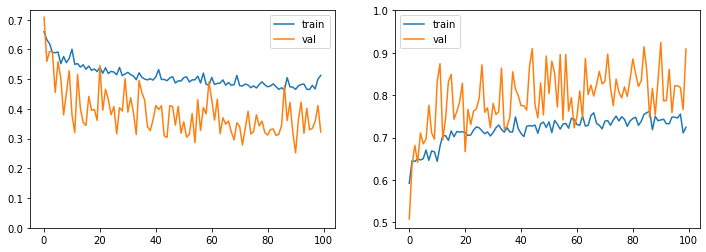

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5803 - accuracy: 0.6718 - precision: 0.9311 - recall: 0.6448 - f1: 0.7529 - specificity: 0.8049 - negative_predictive_value: 0.3374 - matthews_correlation_coefficient: 0.3465 - val_loss: 0.5421 - val_accuracy: 0.6739 - val_precision: 0.9526 - val_recall: 0.6454 - val_f1: 0.7648 - val_specificity: 0.8331 - val_negative_predictive_value: 0.3313 - val_matthews_correlation_coefficient: 0.3652

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.36520, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_28-00_54_26.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5543 - accuracy: 0.6818 - precision: 0.9506 - recall: 0.6448 - f1: 0.7645 - specificity: 0.8404 - negative_predictive_value: 0.3417 - matthews_correlation_coefficient: 0.3739 - val_loss: 0.5800 - val_accuracy: 0.6722 - val_preci


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.39899
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5138 - accuracy: 0.7221 - precision: 0.9489 - recall: 0.6986 - f1: 0.8003 - specificity: 0.8211 - negative_predictive_value: 0.3747 - matthews_correlation_coefficient: 0.4076 - val_loss: 0.5441 - val_accuracy: 0.7034 - val_precision: 0.9563 - val_recall: 0.6799 - val_f1: 0.7902 - val_specificity: 0.8390 - val_negative_predictive_value: 0.3576 - val_matthews_correlation_coefficient: 0.4003

Epoch 00015: val_matthews_correlation_coefficient improved from 0.39899 to 0.40028, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_28-00_54_26.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5050 - accuracy: 0.7380 - precision: 0.9463 - recall: 0.7255 - f1: 0.8170 - specificity: 0.7980 - negative_predictive_value: 0.3901 - matthews_correlation_coefficient: 0.4153 - val_loss: 0.55

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4912 - accuracy: 0.7382 - precision: 0.9490 - recall: 0.7238 - f1: 0.8155 - specificity: 0.8095 - negative_predictive_value: 0.3955 - matthews_correlation_coefficient: 0.4242 - val_loss: 0.5065 - val_accuracy: 0.7251 - val_precision: 0.9471 - val_recall: 0.7149 - val_f1: 0.8107 - val_specificity: 0.8042 - val_negative_predictive_value: 0.3723 - val_matthews_correlation_coefficient: 0.4038

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41325
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4865 - accuracy: 0.7482 - precision: 0.9460 - recall: 0.7350 - f1: 0.8226 - specificity: 0.8086 - negative_predictive_value: 0.4060 - matthews_correlation_coefficient: 0.4332 - val_loss: 0.4717 - val_accuracy: 0.7537 - val_precision: 0.9425 - val_recall: 0.7570 - val_f1: 0.8346 - val_specificity: 0.7718 - val_negative_predictive_value: 0.4061 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4700 - accuracy: 0.7649 - precision: 0.9425 - recall: 0.7622 - f1: 0.8378 - specificity: 0.7737 - negative_predictive_value: 0.4202 - matthews_correlation_coefficient: 0.4389 - val_loss: 0.7072 - val_accuracy: 0.6088 - val_precision: 0.9703 - val_recall: 0.5543 - val_f1: 0.6999 - val_specificity: 0.8941 - val_negative_predictive_value: 0.2968 - val_matthews_correlation_coefficient: 0.3427

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.43585
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4784 - accuracy: 0.7516 - precision: 0.9510 - recall: 0.7391 - f1: 0.8274 - specificity: 0.8297 - negative_predictive_value: 0.4157 - matthews_correlation_coefficient: 0.4532 - val_loss: 0.5152 - val_accuracy: 0.7381 - val_precision: 0.9463 - val_recall: 0.7332 - val_f1: 0.8218 - val_specificity: 0.7912 - val_negative_predictive_value: 0.3869 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4616 - accuracy: 0.7668 - precision: 0.9491 - recall: 0.7581 - f1: 0.8385 - specificity: 0.8048 - negative_predictive_value: 0.4325 - matthews_correlation_coefficient: 0.4582 - val_loss: 0.5094 - val_accuracy: 0.7277 - val_precision: 0.9469 - val_recall: 0.7186 - val_f1: 0.8132 - val_specificity: 0.8000 - val_negative_predictive_value: 0.3717 - val_matthews_correlation_coefficient: 0.4030

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.43585
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4585 - accuracy: 0.7751 - precision: 0.9483 - recall: 0.7731 - f1: 0.8468 - specificity: 0.8121 - negative_predictive_value: 0.4510 - matthews_correlation_coefficient: 0.4758 - val_loss: 0.5282 - val_accuracy: 0.7207 - val_precision: 0.9539 - val_recall: 0.7037 - val_f1: 0.8059 - val_specificity: 0.8257 - val_negative_predictive_value: 0.3705 - val_matthews_correlation_coefficie

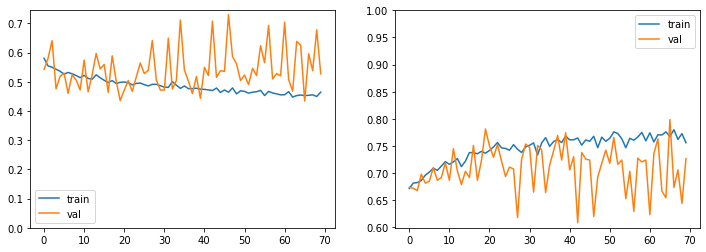

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6410 - accuracy: 0.5341 - precision: 0.8921 - recall: 0.4635 - f1: 0.6001 - specificity: 0.7949 - negative_predictive_value: 0.2801 - matthews_correlation_coefficient: 0.2159 - val_loss: 0.6512 - val_accuracy: 0.4866 - val_precision: 0.9238 - val_recall: 0.4018 - val_f1: 0.5485 - val_specificity: 0.8556 - val_negative_predictive_value: 0.2687 - val_matthews_correlation_coefficient: 0.2209

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.22091, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_28-01_04_55.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6305 - accuracy: 0.5380 - precision: 0.9077 - recall: 0.4681 - f1: 0.6032 - specificity: 0.7975 - negative_predictive_value: 0.2884 - matthews_correlation_coefficient: 0.2286 - val_loss: 0.5999 - val_accuracy: 0.5559 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5866 - accuracy: 0.6395 - precision: 0.9168 - recall: 0.6026 - f1: 0.7168 - specificity: 0.7811 - negative_predictive_value: 0.3496 - matthews_correlation_coefficient: 0.3183 - val_loss: 0.5874 - val_accuracy: 0.6314 - val_precision: 0.9168 - val_recall: 0.6020 - val_f1: 0.7198 - val_specificity: 0.7676 - val_negative_predictive_value: 0.3324 - val_matthews_correlation_coefficient: 0.3021

Epoch 00015: val_matthews_correlation_coefficient improved from 0.29352 to 0.30211, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_28-01_04_55.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5761 - accuracy: 0.6499 - precision: 0.9204 - recall: 0.6139 - f1: 0.7287 - specificity: 0.7901 - negative_predictive_value: 0.3539 - matthews_correlation_coefficient: 0.3315 - val_loss: 0.6188 - val_accuracy: 0.6262 - val_precision: 0.9122 - val_recall: 0.5970 - val_f1: 0.7160 - val_spec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5427 - accuracy: 0.6944 - precision: 0.9187 - recall: 0.6747 - f1: 0.7701 - specificity: 0.7414 - negative_predictive_value: 0.3858 - matthews_correlation_coefficient: 0.3553 - val_loss: 0.5608 - val_accuracy: 0.6722 - val_precision: 0.9018 - val_recall: 0.6694 - val_f1: 0.7644 - val_specificity: 0.6964 - val_negative_predictive_value: 0.3514 - val_matthews_correlation_coefficient: 0.3029

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.33252
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5443 - accuracy: 0.6861 - precision: 0.9052 - recall: 0.6695 - f1: 0.7626 - specificity: 0.7333 - negative_predictive_value: 0.3848 - matthews_correlation_coefficient: 0.3405 - val_loss: 0.6378 - val_accuracy: 0.6245 - val_precision: 0.9191 - val_recall: 0.5894 - val_f1: 0.7123 - val_specificity: 0.7839 - val_negative_predictive_value: 0.3301 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5255 - accuracy: 0.7072 - precision: 0.9163 - recall: 0.6860 - f1: 0.7772 - specificity: 0.7701 - negative_predictive_value: 0.4069 - matthews_correlation_coefficient: 0.3799 - val_loss: 0.5103 - val_accuracy: 0.7155 - val_precision: 0.8941 - val_recall: 0.7378 - val_f1: 0.8050 - val_specificity: 0.6421 - val_negative_predictive_value: 0.3853 - val_matthews_correlation_coefficient: 0.3241

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.33252
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5206 - accuracy: 0.7158 - precision: 0.9226 - recall: 0.7066 - f1: 0.7928 - specificity: 0.7728 - negative_predictive_value: 0.4203 - matthews_correlation_coefficient: 0.4013 - val_loss: 0.5460 - val_accuracy: 0.6956 - val_precision: 0.9042 - val_recall: 0.6979 - val_f1: 0.7846 - val_specificity: 0.6951 - val_negative_predictive_value: 0.3720 - val_matthews_correlation_coefficie

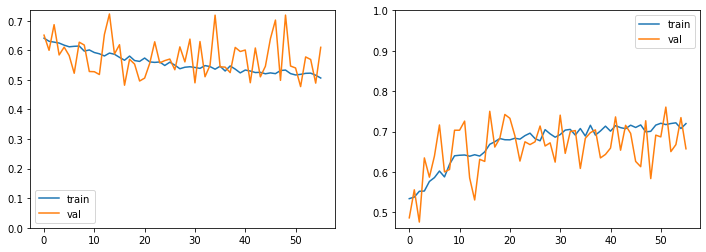

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5101 - accuracy: 0.7271 - precision: 0.7878 - recall: 0.6931 - f1: 0.7095 - specificity: 0.7697 - negative_predictive_value: 0.7075 - matthews_correlation_coefficient: 0.4831 - val_loss: 0.4165 - val_accuracy: 0.7944 - val_precision: 0.7354 - val_recall: 0.8836 - val_f1: 0.7994 - val_specificity: 0.6405 - val_negative_predictive_value: 0.8356 - val_matthews_correlation_coefficient: 0.5734

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.57338, saving model to ../models/autoencoders_requirements/varied_background_2020_03_28-01_13_21.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4282 - accuracy: 0.7779 - precision: 0.8167 - recall: 0.7644 - f1: 0.7746 - specificity: 0.7909 - negative_predictive_value: 0.7592 - matthews_correlation_coefficient: 0.5663 - val_loss: 0.3834 - val_accuracy: 0.8135 - val_prec


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.66076
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3515 - accuracy: 0.8223 - precision: 0.8683 - recall: 0.8066 - f1: 0.8267 - specificity: 0.8502 - negative_predictive_value: 0.7925 - matthews_correlation_coefficient: 0.6583 - val_loss: 0.3296 - val_accuracy: 0.8300 - val_precision: 0.8838 - val_recall: 0.7381 - val_f1: 0.8009 - val_specificity: 0.8890 - val_negative_predictive_value: 0.7418 - val_matthews_correlation_coefficient: 0.6529

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.66076
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3325 - accuracy: 0.8351 - precision: 0.8728 - recall: 0.8175 - f1: 0.8370 - specificity: 0.8566 - negative_predictive_value: 0.7949 - matthews_correlation_coefficient: 0.6723 - val_loss: 0.3095 - val_accuracy: 0.8387 - val_precision: 0.8261 - val_recall: 0.8235 - val_f1: 0.8226 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3202 - accuracy: 0.8469 - precision: 0.8732 - recall: 0.8467 - f1: 0.8543 - specificity: 0.8470 - negative_predictive_value: 0.8173 - matthews_correlation_coefficient: 0.6919 - val_loss: 0.3356 - val_accuracy: 0.8404 - val_precision: 0.8951 - val_recall: 0.7515 - val_f1: 0.8142 - val_specificity: 0.8973 - val_negative_predictive_value: 0.7504 - val_matthews_correlation_coefficient: 0.6737

Epoch 00029: val_matthews_correlation_coefficient improved from 0.67249 to 0.67373, saving model to ../models/autoencoders_requirements/varied_background_2020_03_28-01_13_21.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3198 - accuracy: 0.8436 - precision: 0.8722 - recall: 0.8285 - f1: 0.8428 - specificity: 0.8588 - negative_predictive_value: 0.8167 - matthews_correlation_coefficient: 0.6895 - val_loss: 0.3021 - val_accuracy: 0.8508 - val_precision: 0.8166 - val_recall: 0.8645 - val_f1: 0.8381 - va

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2987 - accuracy: 0.8557 - precision: 0.8801 - recall: 0.8528 - f1: 0.8612 - specificity: 0.8607 - negative_predictive_value: 0.8232 - matthews_correlation_coefficient: 0.7098 - val_loss: 0.2911 - val_accuracy: 0.8586 - val_precision: 0.8741 - val_recall: 0.8095 - val_f1: 0.8378 - val_specificity: 0.8674 - val_negative_predictive_value: 0.7931 - val_matthews_correlation_coefficient: 0.6988

Epoch 00043: val_matthews_correlation_coefficient improved from 0.69681 to 0.69878, saving model to ../models/autoencoders_requirements/varied_background_2020_03_28-01_13_21.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2953 - accuracy: 0.8564 - precision: 0.8895 - recall: 0.8480 - f1: 0.8631 - specificity: 0.8721 - negative_predictive_value: 0.8275 - matthews_correlation_coefficient: 0.7181 - val_loss: 0.2785 - val_accuracy: 0.8612 - val_precision: 0.8428 - val_recall: 0.8550 - val_f1: 0.8464 - va

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2924 - accuracy: 0.8631 - precision: 0.8768 - recall: 0.8616 - f1: 0.8632 - specificity: 0.8598 - negative_predictive_value: 0.8498 - matthews_correlation_coefficient: 0.7236 - val_loss: 0.2853 - val_accuracy: 0.8534 - val_precision: 0.8404 - val_recall: 0.8388 - val_f1: 0.8372 - val_specificity: 0.8192 - val_negative_predictive_value: 0.8160 - val_matthews_correlation_coefficient: 0.6841

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.72301
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2809 - accuracy: 0.8623 - precision: 0.8915 - recall: 0.8535 - f1: 0.8671 - specificity: 0.8772 - negative_predictive_value: 0.8362 - matthews_correlation_coefficient: 0.7290 - val_loss: 0.2749 - val_accuracy: 0.8638 - val_precision: 0.8381 - val_recall: 0.8637 - val_f1: 0.8489 - val_specificity: 0.8109 - val_negative_predictive_value: 0.8378 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2705 - accuracy: 0.8722 - precision: 0.8966 - recall: 0.8656 - f1: 0.8757 - specificity: 0.8809 - negative_predictive_value: 0.8398 - matthews_correlation_coefficient: 0.7428 - val_loss: 0.3041 - val_accuracy: 0.8534 - val_precision: 0.8028 - val_recall: 0.8964 - val_f1: 0.8450 - val_specificity: 0.7492 - val_negative_predictive_value: 0.8674 - val_matthews_correlation_coefficient: 0.6844

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.72301
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2725 - accuracy: 0.8677 - precision: 0.8888 - recall: 0.8514 - f1: 0.8661 - specificity: 0.8827 - negative_predictive_value: 0.8416 - matthews_correlation_coefficient: 0.7321 - val_loss: 0.2696 - val_accuracy: 0.8656 - val_precision: 0.8555 - val_recall: 0.8470 - val_f1: 0.8492 - val_specificity: 0.8362 - val_negative_predictive_value: 0.8215 - val_matthews_correlation_coefficie

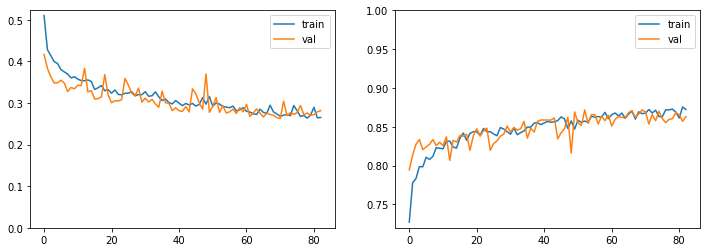

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6099 - accuracy: 0.6983 - precision: 0.8698 - recall: 0.6981 - f1: 0.7656 - specificity: 0.6947 - negative_predictive_value: 0.4554 - matthews_correlation_coefficient: 0.3572 - val_loss: 0.5726 - val_accuracy: 0.7016 - val_precision: 0.8778 - val_recall: 0.6520 - val_f1: 0.7425 - val_specificity: 0.8057 - val_negative_predictive_value: 0.4869 - val_matthews_correlation_coefficient: 0.4066

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.40664, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_28-01_25_44.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5942 - accuracy: 0.7011 - precision: 0.8787 - recall: 0.6750 - f1: 0.7598 - specificity: 0.7636 - negative_predictive_value: 0.4675 - matthews_correlation_coefficient: 0.3889 - val_loss: 0.6838 - val_accuracy: 0.6878 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5824 - accuracy: 0.6972 - precision: 0.8911 - recall: 0.6700 - f1: 0.7608 - specificity: 0.7702 - negative_predictive_value: 0.4651 - matthews_correlation_coefficient: 0.3949 - val_loss: 0.6183 - val_accuracy: 0.6947 - val_precision: 0.8850 - val_recall: 0.6364 - val_f1: 0.7345 - val_specificity: 0.8254 - val_negative_predictive_value: 0.4807 - val_matthews_correlation_coefficient: 0.4091

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.40935
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5770 - accuracy: 0.7037 - precision: 0.8915 - recall: 0.6767 - f1: 0.7655 - specificity: 0.7700 - negative_predictive_value: 0.4667 - matthews_correlation_coefficient: 0.3994 - val_loss: 0.5739 - val_accuracy: 0.7008 - val_precision: 0.8802 - val_recall: 0.6487 - val_f1: 0.7412 - val_specificity: 0.8122 - val_negative_predictive_value: 0.4861 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41084
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5753 - accuracy: 0.6967 - precision: 0.8903 - recall: 0.6686 - f1: 0.7585 - specificity: 0.7744 - negative_predictive_value: 0.4613 - matthews_correlation_coefficient: 0.3945 - val_loss: 0.6081 - val_accuracy: 0.6722 - val_precision: 0.8859 - val_recall: 0.6002 - val_f1: 0.7100 - val_specificity: 0.8439 - val_negative_predictive_value: 0.4591 - val_matthews_correlation_coefficient: 0.3893

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.41084
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5723 - accuracy: 0.7069 - precision: 0.8906 - recall: 0.6842 - f1: 0.7699 - specificity: 0.7761 - negative_predictive_value: 0.4758 - matthews_correlation_coefficient: 0.4089 - val_loss: 0.6162 - val_accuracy: 0.6808 - val_precision: 0.8859 - val_recall: 0.6149 - val_f1: 0.7197 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.41125
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5752 - accuracy: 0.6993 - precision: 0.8938 - recall: 0.6687 - f1: 0.7608 - specificity: 0.7752 - negative_predictive_value: 0.4622 - matthews_correlation_coefficient: 0.3974 - val_loss: 0.5914 - val_accuracy: 0.6869 - val_precision: 0.8834 - val_recall: 0.6249 - val_f1: 0.7261 - val_specificity: 0.8309 - val_negative_predictive_value: 0.4731 - val_matthews_correlation_coefficient: 0.4011

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.41125
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5671 - accuracy: 0.7117 - precision: 0.8864 - recall: 0.6844 - f1: 0.7682 - specificity: 0.7724 - negative_predictive_value: 0.4733 - matthews_correlation_coefficient: 0.4039 - val_loss: 0.5866 - val_accuracy: 0.6912 - val_precision: 0.8804 - val_recall: 0.6334 - val_f1: 0.7308 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.41307
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5607 - accuracy: 0.7106 - precision: 0.8962 - recall: 0.6831 - f1: 0.7709 - specificity: 0.7797 - negative_predictive_value: 0.4769 - matthews_correlation_coefficient: 0.4152 - val_loss: 0.6028 - val_accuracy: 0.6739 - val_precision: 0.8857 - val_recall: 0.6046 - val_f1: 0.7125 - val_specificity: 0.8441 - val_negative_predictive_value: 0.4619 - val_matthews_correlation_coefficient: 0.3928

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.41307
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5584 - accuracy: 0.7124 - precision: 0.9001 - recall: 0.6832 - f1: 0.7727 - specificity: 0.7909 - negative_predictive_value: 0.4770 - matthews_correlation_coefficient: 0.4225 - val_loss: 0.6216 - val_accuracy: 0.6852 - val_precision: 0.8805 - val_recall: 0.6239 - val_f1: 0.7242 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.41446
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5545 - accuracy: 0.7119 - precision: 0.8960 - recall: 0.6878 - f1: 0.7728 - specificity: 0.7835 - negative_predictive_value: 0.4788 - matthews_correlation_coefficient: 0.4206 - val_loss: 0.6002 - val_accuracy: 0.6583 - val_precision: 0.8755 - val_recall: 0.5899 - val_f1: 0.6981 - val_specificity: 0.8317 - val_negative_predictive_value: 0.4500 - val_matthews_correlation_coefficient: 0.3684

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.41446
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5513 - accuracy: 0.7124 - precision: 0.9011 - recall: 0.6852 - f1: 0.7744 - specificity: 0.7846 - negative_predictive_value: 0.4777 - matthews_correlation_coefficient: 0.4199 - val_loss: 0.5740 - val_accuracy: 0.7016 - val_precision: 0.8795 - val_recall: 0.6501 - val_f1: 0.7414 - val_spe


Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.42451
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5529 - accuracy: 0.7143 - precision: 0.8934 - recall: 0.6934 - f1: 0.7777 - specificity: 0.7722 - negative_predictive_value: 0.4790 - matthews_correlation_coefficient: 0.4143 - val_loss: 0.5937 - val_accuracy: 0.7069 - val_precision: 0.8860 - val_recall: 0.6514 - val_f1: 0.7451 - val_specificity: 0.8308 - val_negative_predictive_value: 0.4931 - val_matthews_correlation_coefficient: 0.4255

Epoch 00090: val_matthews_correlation_coefficient improved from 0.42451 to 0.42549, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_28-01_25_44.h5
Epoch 91/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5473 - accuracy: 0.7163 - precision: 0.8975 - recall: 0.6933 - f1: 0.7784 - specificity: 0.7789 - negative_predictive_value: 0.4791 - matthews_correlation_coefficient: 0.4198 - val_loss: 0.5524

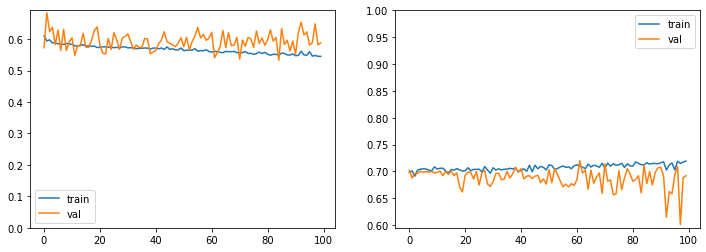

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6331 - accuracy: 0.6369 - precision: 0.6437 - recall: 0.6828 - f1: 0.6268 - specificity: 0.5885 - negative_predictive_value: 0.6654 - matthews_correlation_coefficient: 0.2935 - val_loss: 0.6226 - val_accuracy: 0.6340 - val_precision: 0.7208 - val_recall: 0.4342 - val_f1: 0.5312 - val_specificity: 0.8128 - val_negative_predictive_value: 0.5741 - val_matthews_correlation_coefficient: 0.2958

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29579, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_28-01_40_38.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5855 - accuracy: 0.6991 - precision: 0.6909 - recall: 0.7591 - f1: 0.7077 - specificity: 0.6384 - negative_predictive_value: 0.7311 - matthews_correlation_coefficient: 0.4107 - val_loss: 0.6013 - val_accuracy: 0.6704 - v


Epoch 00014: val_matthews_correlation_coefficient improved from 0.46065 to 0.50434, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_28-01_40_38.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4941 - accuracy: 0.7497 - precision: 0.7260 - recall: 0.8113 - f1: 0.7581 - specificity: 0.6866 - negative_predictive_value: 0.7864 - matthews_correlation_coefficient: 0.5064 - val_loss: 0.5025 - val_accuracy: 0.7415 - val_precision: 0.7066 - val_recall: 0.7798 - val_f1: 0.7356 - val_specificity: 0.6622 - val_negative_predictive_value: 0.7473 - val_matthews_correlation_coefficient: 0.4743

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.50434
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4799 - accuracy: 0.7538 - precision: 0.7383 - recall: 0.8099 - f1: 0.7649 - specificity: 0.6950 - negative_predictive_value: 0.7757 - matthews_correlation_coefficient: 0.5089 - val_lo

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4656 - accuracy: 0.7675 - precision: 0.7534 - recall: 0.7974 - f1: 0.7662 - specificity: 0.7294 - negative_predictive_value: 0.7879 - matthews_correlation_coefficient: 0.5352 - val_loss: 0.4825 - val_accuracy: 0.7554 - val_precision: 0.7301 - val_recall: 0.8623 - val_f1: 0.7848 - val_specificity: 0.6312 - val_negative_predictive_value: 0.7893 - val_matthews_correlation_coefficient: 0.5051

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.50754
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4586 - accuracy: 0.7722 - precision: 0.7633 - recall: 0.8099 - f1: 0.7776 - specificity: 0.7302 - negative_predictive_value: 0.7913 - matthews_correlation_coefficient: 0.5487 - val_loss: 0.4827 - val_accuracy: 0.7502 - val_precision: 0.7603 - val_recall: 0.7020 - val_f1: 0.7246 - val_specificity: 0.7655 - val_negative_predictive_value: 0.7051 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.51896
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4349 - accuracy: 0.7913 - precision: 0.7795 - recall: 0.8214 - f1: 0.7928 - specificity: 0.7520 - negative_predictive_value: 0.8044 - matthews_correlation_coefficient: 0.5853 - val_loss: 0.4819 - val_accuracy: 0.7624 - val_precision: 0.7314 - val_recall: 0.7921 - val_f1: 0.7551 - val_specificity: 0.6905 - val_negative_predictive_value: 0.7588 - val_matthews_correlation_coefficient: 0.5128

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.51896
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4406 - accuracy: 0.7861 - precision: 0.7870 - recall: 0.8068 - f1: 0.7907 - specificity: 0.7712 - negative_predictive_value: 0.7951 - matthews_correlation_coefficient: 0.5799 - val_loss: 0.4871 - val_accuracy: 0.7624 - val_precision: 0.7317 - val_recall: 0.7879 - val_f1: 0.7543 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.53318
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4226 - accuracy: 0.7963 - precision: 0.7922 - recall: 0.8210 - f1: 0.7999 - specificity: 0.7742 - negative_predictive_value: 0.8092 - matthews_correlation_coefficient: 0.5980 - val_loss: 0.4750 - val_accuracy: 0.7598 - val_precision: 0.7300 - val_recall: 0.8718 - val_f1: 0.7892 - val_specificity: 0.6295 - val_negative_predictive_value: 0.7981 - val_matthews_correlation_coefficient: 0.5135

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.53318
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4178 - accuracy: 0.7983 - precision: 0.7925 - recall: 0.8228 - f1: 0.8020 - specificity: 0.7685 - negative_predictive_value: 0.8049 - matthews_correlation_coefficient: 0.5941 - val_loss: 0.4769 - val_accuracy: 0.7598 - val_precision: 0.7370 - val_recall: 0.8641 - val_f1: 0.7888 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4133 - accuracy: 0.8043 - precision: 0.7938 - recall: 0.8241 - f1: 0.8013 - specificity: 0.7797 - negative_predictive_value: 0.8190 - matthews_correlation_coefficient: 0.6097 - val_loss: 0.4803 - val_accuracy: 0.7684 - val_precision: 0.7736 - val_recall: 0.7278 - val_f1: 0.7449 - val_specificity: 0.7759 - val_negative_predictive_value: 0.7255 - val_matthews_correlation_coefficient: 0.5282

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.53950
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4111 - accuracy: 0.8061 - precision: 0.7937 - recall: 0.8246 - f1: 0.8011 - specificity: 0.7809 - negative_predictive_value: 0.8226 - matthews_correlation_coefficient: 0.6104 - val_loss: 0.5052 - val_accuracy: 0.7632 - val_precision: 0.7939 - val_recall: 0.6818 - val_f1: 0.7293 - val_specificity: 0.8097 - val_negative_predictive_value: 0.7018 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.55895
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4079 - accuracy: 0.8085 - precision: 0.8083 - recall: 0.8272 - f1: 0.8094 - specificity: 0.7983 - negative_predictive_value: 0.8209 - matthews_correlation_coefficient: 0.6270 - val_loss: 0.4831 - val_accuracy: 0.7632 - val_precision: 0.7273 - val_recall: 0.8941 - val_f1: 0.7968 - val_specificity: 0.6126 - val_negative_predictive_value: 0.8185 - val_matthews_correlation_coefficient: 0.5244

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.55895
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4038 - accuracy: 0.8134 - precision: 0.8087 - recall: 0.8394 - f1: 0.8173 - specificity: 0.7903 - negative_predictive_value: 0.8149 - matthews_correlation_coefficient: 0.6264 - val_loss: 0.4576 - val_accuracy: 0.7797 - val_precision: 0.7663 - val_recall: 0.8475 - val_f1: 0.7986 - val_spe

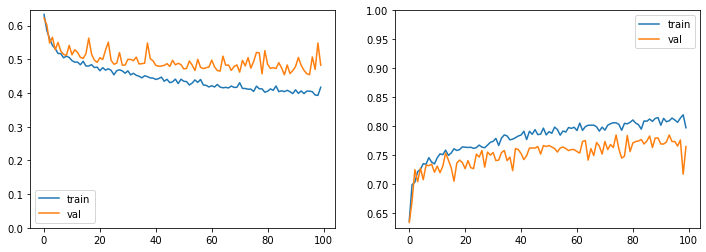

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6502 - accuracy: 0.5401 - precision: 0.8792 - recall: 0.4744 - f1: 0.6033 - specificity: 0.7769 - negative_predictive_value: 0.2901 - matthews_correlation_coefficient: 0.2145 - val_loss: 0.6733 - val_accuracy: 0.4883 - val_precision: 0.9340 - val_recall: 0.3957 - val_f1: 0.5455 - val_specificity: 0.8688 - val_negative_predictive_value: 0.2740 - val_matthews_correlation_coefficient: 0.2324

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.23237, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_28-01_55_32.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6334 - accuracy: 0.5401 - precision: 0.9103 - recall: 0.4685 - f1: 0.6036 - specificity: 0.7981 - negative_predictive_value: 0.2846 - matthews_correlation_coefficient: 0.2275 - val_loss: 0.6343 - val_accuracy: 0.5403 - val_precision: 0


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.35870
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5762 - accuracy: 0.6477 - precision: 0.9100 - recall: 0.6092 - f1: 0.7212 - specificity: 0.7891 - negative_predictive_value: 0.3586 - matthews_correlation_coefficient: 0.3309 - val_loss: 0.6168 - val_accuracy: 0.5906 - val_precision: 0.9333 - val_recall: 0.5326 - val_f1: 0.6720 - val_specificity: 0.8359 - val_negative_predictive_value: 0.3189 - val_matthews_correlation_coefficient: 0.3035

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.35870
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5689 - accuracy: 0.6701 - precision: 0.9087 - recall: 0.6490 - f1: 0.7486 - specificity: 0.7520 - negative_predictive_value: 0.3794 - matthews_correlation_coefficient: 0.3380 - val_loss: 0.5491 - val_accuracy: 0.6808 - val_precision: 0.9255 - val_recall: 0.6580 - val_f1: 0.7648 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5480 - accuracy: 0.6876 - precision: 0.9182 - recall: 0.6647 - f1: 0.7630 - specificity: 0.7617 - negative_predictive_value: 0.3880 - matthews_correlation_coefficient: 0.3610 - val_loss: 0.5519 - val_accuracy: 0.6921 - val_precision: 0.9119 - val_recall: 0.6856 - val_f1: 0.7789 - val_specificity: 0.7303 - val_negative_predictive_value: 0.3778 - val_matthews_correlation_coefficient: 0.3458

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38556
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5469 - accuracy: 0.6866 - precision: 0.9083 - recall: 0.6606 - f1: 0.7560 - specificity: 0.7623 - negative_predictive_value: 0.3896 - matthews_correlation_coefficient: 0.3584 - val_loss: 0.5260 - val_accuracy: 0.7251 - val_precision: 0.9115 - val_recall: 0.7299 - val_f1: 0.8070 - val_specificity: 0.7177 - val_negative_predictive_value: 0.4105 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.38556
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5173 - accuracy: 0.7178 - precision: 0.9238 - recall: 0.7015 - f1: 0.7912 - specificity: 0.7805 - negative_predictive_value: 0.4245 - matthews_correlation_coefficient: 0.4066 - val_loss: 0.5320 - val_accuracy: 0.6990 - val_precision: 0.9103 - val_recall: 0.6974 - val_f1: 0.7857 - val_specificity: 0.7231 - val_negative_predictive_value: 0.3885 - val_matthews_correlation_coefficient: 0.3530

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.38556
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5256 - accuracy: 0.7069 - precision: 0.9177 - recall: 0.6948 - f1: 0.7827 - specificity: 0.7574 - negative_predictive_value: 0.4113 - matthews_correlation_coefficient: 0.3825 - val_loss: 0.6151 - val_accuracy: 0.6670 - val_precision: 0.8976 - val_recall: 0.6629 - val_f1: 0.7578 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.38556
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5083 - accuracy: 0.7282 - precision: 0.9213 - recall: 0.7202 - f1: 0.8025 - specificity: 0.7754 - negative_predictive_value: 0.4358 - matthews_correlation_coefficient: 0.4165 - val_loss: 0.5447 - val_accuracy: 0.7086 - val_precision: 0.9173 - val_recall: 0.7041 - val_f1: 0.7929 - val_specificity: 0.7328 - val_negative_predictive_value: 0.3954 - val_matthews_correlation_coefficient: 0.3681

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.38556
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5170 - accuracy: 0.7215 - precision: 0.9217 - recall: 0.7094 - f1: 0.7949 - specificity: 0.7660 - negative_predictive_value: 0.4265 - matthews_correlation_coefficient: 0.4036 - val_loss: 0.6434 - val_accuracy: 0.6305 - val_precision: 0.9397 - val_recall: 0.5809 - val_f1: 0.7112 - val_spe

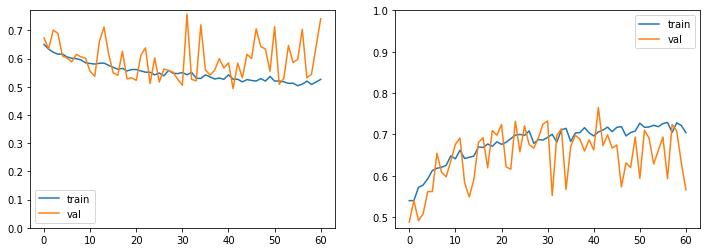

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4685 - accuracy: 0.7603 - precision: 0.8695 - recall: 0.7465 - f1: 0.7936 - specificity: 0.8006 - negative_predictive_value: 0.6497 - matthews_correlation_coefficient: 0.5318 - val_loss: 0.5014 - val_accuracy: 0.7268 - val_precision: 0.9046 - val_recall: 0.6098 - val_f1: 0.7213 - val_specificity: 0.9185 - val_negative_predictive_value: 0.5913 - val_matthews_correlation_coefficient: 0.5107

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.51075, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_28-02_04_49.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4044 - accuracy: 0.7905 - precision: 0.9014 - recall: 0.7613 - f1: 0.8193 - specificity: 0.8541 - negative_predictive_value: 0.6715 - matthews_correlation_coefficient: 0.5925 - val_loss: 0.4629 - val_accuracy: 0.7502 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.66424
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3486 - accuracy: 0.8295 - precision: 0.9145 - recall: 0.8120 - f1: 0.8545 - specificity: 0.8624 - negative_predictive_value: 0.7136 - matthews_correlation_coefficient: 0.6512 - val_loss: 0.3511 - val_accuracy: 0.8378 - val_precision: 0.8739 - val_recall: 0.8172 - val_f1: 0.8430 - val_specificity: 0.8363 - val_negative_predictive_value: 0.7443 - val_matthews_correlation_coefficient: 0.6352

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.66424
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3414 - accuracy: 0.8351 - precision: 0.9196 - recall: 0.8190 - f1: 0.8617 - specificity: 0.8661 - negative_predictive_value: 0.7263 - matthews_correlation_coefficient: 0.6642 - val_loss: 0.3324 - val_accuracy: 0.8387 - val_precision: 0.8254 - val_recall: 0.8847 - val_f1: 0.8520 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3160 - accuracy: 0.8553 - precision: 0.9201 - recall: 0.8489 - f1: 0.8787 - specificity: 0.8693 - negative_predictive_value: 0.7612 - matthews_correlation_coefficient: 0.7001 - val_loss: 0.3789 - val_accuracy: 0.8179 - val_precision: 0.9223 - val_recall: 0.7388 - val_f1: 0.8170 - val_specificity: 0.9232 - val_negative_predictive_value: 0.6884 - val_matthews_correlation_coefficient: 0.6350

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.69708
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3243 - accuracy: 0.8518 - precision: 0.9255 - recall: 0.8410 - f1: 0.8773 - specificity: 0.8778 - negative_predictive_value: 0.7600 - matthews_correlation_coefficient: 0.7009 - val_loss: 0.3140 - val_accuracy: 0.8777 - val_precision: 0.8967 - val_recall: 0.8612 - val_f1: 0.8768 - val_specificity: 0.8718 - val_negative_predictive_value: 0.8070 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.72209
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3042 - accuracy: 0.8638 - precision: 0.9149 - recall: 0.8546 - f1: 0.8800 - specificity: 0.8654 - negative_predictive_value: 0.7825 - matthews_correlation_coefficient: 0.7144 - val_loss: 0.4049 - val_accuracy: 0.8040 - val_precision: 0.9352 - val_recall: 0.7054 - val_f1: 0.7996 - val_specificity: 0.9438 - val_negative_predictive_value: 0.6680 - val_matthews_correlation_coefficient: 0.6247

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.72209
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3233 - accuracy: 0.8492 - precision: 0.9250 - recall: 0.8323 - f1: 0.8696 - specificity: 0.8841 - negative_predictive_value: 0.7486 - matthews_correlation_coefficient: 0.6953 - val_loss: 0.3587 - val_accuracy: 0.8309 - val_precision: 0.9229 - val_recall: 0.7609 - val_f1: 0.8307 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2806 - accuracy: 0.8761 - precision: 0.9295 - recall: 0.8736 - f1: 0.8979 - specificity: 0.8812 - negative_predictive_value: 0.7920 - matthews_correlation_coefficient: 0.7371 - val_loss: 0.2996 - val_accuracy: 0.8708 - val_precision: 0.8943 - val_recall: 0.8565 - val_f1: 0.8726 - val_specificity: 0.8582 - val_negative_predictive_value: 0.7925 - val_matthews_correlation_coefficient: 0.7001

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.72882
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2875 - accuracy: 0.8716 - precision: 0.9234 - recall: 0.8710 - f1: 0.8920 - specificity: 0.8732 - negative_predictive_value: 0.7890 - matthews_correlation_coefficient: 0.7288 - val_loss: 0.3408 - val_accuracy: 0.8413 - val_precision: 0.9263 - val_recall: 0.7740 - val_f1: 0.8391 - val_specificity: 0.9249 - val_negative_predictive_value: 0.7256 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.73753
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2767 - accuracy: 0.8757 - precision: 0.9227 - recall: 0.8702 - f1: 0.8912 - specificity: 0.8764 - negative_predictive_value: 0.8014 - matthews_correlation_coefficient: 0.7411 - val_loss: 0.3200 - val_accuracy: 0.8526 - val_precision: 0.8862 - val_recall: 0.8346 - val_f1: 0.8562 - val_specificity: 0.8561 - val_negative_predictive_value: 0.7703 - val_matthews_correlation_coefficient: 0.6726

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.73753
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2763 - accuracy: 0.8727 - precision: 0.9279 - recall: 0.8688 - f1: 0.8936 - specificity: 0.8738 - negative_predictive_value: 0.7930 - matthews_correlation_coefficient: 0.7325 - val_loss: 0.2995 - val_accuracy: 0.8699 - val_precision: 0.8804 - val_recall: 0.8684 - val_f1: 0.8717 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2806 - accuracy: 0.8748 - precision: 0.9394 - recall: 0.8633 - f1: 0.8968 - specificity: 0.8976 - negative_predictive_value: 0.7802 - matthews_correlation_coefficient: 0.7391 - val_loss: 0.2976 - val_accuracy: 0.8812 - val_precision: 0.8958 - val_recall: 0.8703 - val_f1: 0.8805 - val_specificity: 0.8630 - val_negative_predictive_value: 0.8205 - val_matthews_correlation_coefficient: 0.7241

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.74237
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2571 - accuracy: 0.8876 - precision: 0.9347 - recall: 0.8896 - f1: 0.9089 - specificity: 0.8838 - negative_predictive_value: 0.8116 - matthews_correlation_coefficient: 0.7589 - val_loss: 0.2932 - val_accuracy: 0.8838 - val_precision: 0.8857 - val_recall: 0.8828 - val_f1: 0.8823 - val_specificity: 0.8468 - val_negative_predictive_value: 0.8359 - val_matthews_correlation_coefficie

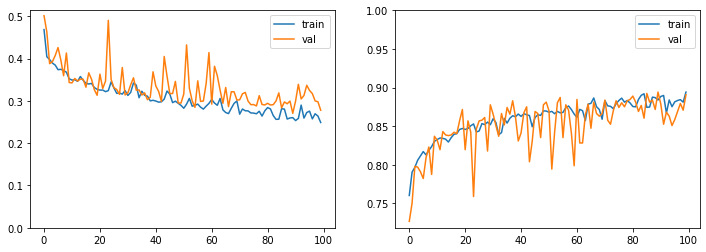

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5940 - accuracy: 0.6685 - precision: 0.7705 - recall: 0.6559 - f1: 0.6943 - specificity: 0.6811 - negative_predictive_value: 0.5671 - matthews_correlation_coefficient: 0.3364 - val_loss: 0.5327 - val_accuracy: 0.7580 - val_precision: 0.7277 - val_recall: 0.8917 - val_f1: 0.7989 - val_specificity: 0.4908 - val_negative_predictive_value: 0.7632 - val_matthews_correlation_coefficient: 0.4590

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.45899, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_28-02_19_47.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5673 - accuracy: 0.7017 - precision: 0.7855 - recall: 0.7034 - f1: 0.7307 - specificity: 0.6936 - negative_predictive_value: 0.6116 - matthews_correlation_coefficient: 0.4027 - val_loss: 0.5389 - val_accuracy: 0.7095 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4884 - accuracy: 0.7746 - precision: 0.8390 - recall: 0.7931 - f1: 0.8088 - specificity: 0.7520 - negative_predictive_value: 0.7003 - matthews_correlation_coefficient: 0.5410 - val_loss: 0.5030 - val_accuracy: 0.7450 - val_precision: 0.8107 - val_recall: 0.7130 - val_f1: 0.7558 - val_specificity: 0.7457 - val_negative_predictive_value: 0.6194 - val_matthews_correlation_coefficient: 0.4709

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.56271
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4819 - accuracy: 0.7731 - precision: 0.8411 - recall: 0.7863 - f1: 0.8056 - specificity: 0.7607 - negative_predictive_value: 0.6949 - matthews_correlation_coefficient: 0.5404 - val_loss: 0.4762 - val_accuracy: 0.7797 - val_precision: 0.8077 - val_recall: 0.7870 - val_f1: 0.7940 - val_specificity: 0.7202 - val_negative_predictive_value: 0.6858 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.56470
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4581 - accuracy: 0.7976 - precision: 0.8543 - recall: 0.8192 - f1: 0.8283 - specificity: 0.7662 - negative_predictive_value: 0.7271 - matthews_correlation_coefficient: 0.5842 - val_loss: 0.4972 - val_accuracy: 0.7580 - val_precision: 0.8287 - val_recall: 0.7125 - val_f1: 0.7636 - val_specificity: 0.8038 - val_negative_predictive_value: 0.6563 - val_matthews_correlation_coefficient: 0.5000

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.56470
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4547 - accuracy: 0.7957 - precision: 0.8412 - recall: 0.8150 - f1: 0.8225 - specificity: 0.7603 - negative_predictive_value: 0.7293 - matthews_correlation_coefficient: 0.5738 - val_loss: 0.6472 - val_accuracy: 0.6644 - val_precision: 0.8079 - val_recall: 0.5542 - val_f1: 0.6534 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.57638
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4354 - accuracy: 0.8117 - precision: 0.8574 - recall: 0.8222 - f1: 0.8349 - specificity: 0.7888 - negative_predictive_value: 0.7401 - matthews_correlation_coefficient: 0.6051 - val_loss: 0.4630 - val_accuracy: 0.7832 - val_precision: 0.8370 - val_recall: 0.7514 - val_f1: 0.7894 - val_specificity: 0.7821 - val_negative_predictive_value: 0.6679 - val_matthews_correlation_coefficient: 0.5456

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.57638
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4505 - accuracy: 0.7952 - precision: 0.8456 - recall: 0.8083 - f1: 0.8208 - specificity: 0.7680 - negative_predictive_value: 0.7213 - matthews_correlation_coefficient: 0.5778 - val_loss: 0.4962 - val_accuracy: 0.7736 - val_precision: 0.8066 - val_recall: 0.7748 - val_f1: 0.7883 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.59893
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4226 - accuracy: 0.8176 - precision: 0.8662 - recall: 0.8397 - f1: 0.8486 - specificity: 0.7851 - negative_predictive_value: 0.7454 - matthews_correlation_coefficient: 0.6175 - val_loss: 0.4428 - val_accuracy: 0.8040 - val_precision: 0.7832 - val_recall: 0.8785 - val_f1: 0.8255 - val_specificity: 0.6265 - val_negative_predictive_value: 0.7833 - val_matthews_correlation_coefficient: 0.5606

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.59893
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4227 - accuracy: 0.8067 - precision: 0.8633 - recall: 0.8237 - f1: 0.8382 - specificity: 0.7776 - negative_predictive_value: 0.7264 - matthews_correlation_coefficient: 0.5947 - val_loss: 0.4351 - val_accuracy: 0.7962 - val_precision: 0.7795 - val_recall: 0.8675 - val_f1: 0.8185 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.59893
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4115 - accuracy: 0.8232 - precision: 0.8672 - recall: 0.8410 - f1: 0.8496 - specificity: 0.7949 - negative_predictive_value: 0.7538 - matthews_correlation_coefficient: 0.6296 - val_loss: 0.4326 - val_accuracy: 0.8101 - val_precision: 0.8143 - val_recall: 0.8376 - val_f1: 0.8231 - val_specificity: 0.7125 - val_negative_predictive_value: 0.7436 - val_matthews_correlation_coefficient: 0.5803

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.59893
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4131 - accuracy: 0.8154 - precision: 0.8675 - recall: 0.8338 - f1: 0.8448 - specificity: 0.7920 - negative_predictive_value: 0.7426 - matthews_correlation_coefficient: 0.6170 - val_loss: 0.4578 - val_accuracy: 0.7910 - val_precision: 0.7917 - val_recall: 0.8343 - val_f1: 0.8098 - val_spe

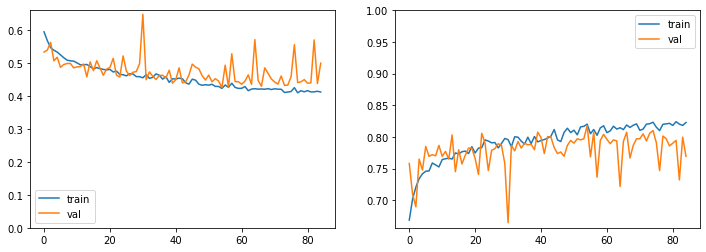

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5830 - accuracy: 0.5458 - precision: 0.9671 - recall: 0.5119 - f1: 0.6608 - specificity: 0.8452 - negative_predictive_value: 0.1871 - matthews_correlation_coefficient: 0.2306 - val_loss: 0.7048 - val_accuracy: 0.4449 - val_precision: 0.9574 - val_recall: 0.3691 - val_f1: 0.5279 - val_specificity: 0.9379 - val_negative_predictive_value: 0.1836 - val_matthews_correlation_coefficient: 0.2068

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20684, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_28-02_32_32.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5708 - accuracy: 0.5312 - precision: 0.9668 - recall: 0.4917 - f1: 0.6395 - specificity: 0.8195 - negative_predictive_value: 0.1817 - matthews_correlation_coefficient: 0.2116 - val_loss: 0.5429 - val_accuracy: 0.5776 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.37307
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4672 - accuracy: 0.7306 - precision: 0.9732 - recall: 0.7179 - f1: 0.8181 - specificity: 0.8248 - negative_predictive_value: 0.2924 - matthews_correlation_coefficient: 0.3706 - val_loss: 0.7291 - val_accuracy: 0.5846 - val_precision: 0.9558 - val_recall: 0.5270 - val_f1: 0.6753 - val_specificity: 0.8672 - val_negative_predictive_value: 0.1990 - val_matthews_correlation_coefficient: 0.2740

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.37307
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4553 - accuracy: 0.7336 - precision: 0.9715 - recall: 0.7249 - f1: 0.8242 - specificity: 0.8140 - negative_predictive_value: 0.2902 - matthews_correlation_coefficient: 0.3648 - val_loss: 0.3526 - val_accuracy: 0.8361 - val_precision: 0.9299 - val_recall: 0.8337 - val_f1: 0.8778 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4014 - accuracy: 0.7655 - precision: 0.9786 - recall: 0.7549 - f1: 0.8446 - specificity: 0.8480 - negative_predictive_value: 0.3336 - matthews_correlation_coefficient: 0.4231 - val_loss: 0.3705 - val_accuracy: 0.8023 - val_precision: 0.9502 - val_recall: 0.7765 - val_f1: 0.8521 - val_specificity: 0.7862 - val_negative_predictive_value: 0.3368 - val_matthews_correlation_coefficient: 0.4218

Epoch 00029: val_matthews_correlation_coefficient improved from 0.40947 to 0.42182, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_28-02_32_32.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4376 - accuracy: 0.7397 - precision: 0.9751 - recall: 0.7300 - f1: 0.8247 - specificity: 0.8286 - negative_predictive_value: 0.3063 - matthews_correlation_coefficient: 0.3868 - val_loss: 0.7702 - val_accuracy: 0.5663 - val_precision: 0.9658 - val_recall: 0.5010 - val_f1: 0.6543 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3606 - accuracy: 0.7941 - precision: 0.9807 - recall: 0.7828 - f1: 0.8668 - specificity: 0.8456 - negative_predictive_value: 0.3503 - matthews_correlation_coefficient: 0.4505 - val_loss: 0.5134 - val_accuracy: 0.7164 - val_precision: 0.9634 - val_recall: 0.6689 - val_f1: 0.7868 - val_specificity: 0.9274 - val_negative_predictive_value: 0.2930 - val_matthews_correlation_coefficient: 0.3827

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45192
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3851 - accuracy: 0.7790 - precision: 0.9786 - recall: 0.7689 - f1: 0.8550 - specificity: 0.8388 - negative_predictive_value: 0.3393 - matthews_correlation_coefficient: 0.4316 - val_loss: 0.5628 - val_accuracy: 0.6817 - val_precision: 0.9646 - val_recall: 0.6292 - val_f1: 0.7578 - val_specificity: 0.9315 - val_negative_predictive_value: 0.2707 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3494 - accuracy: 0.8011 - precision: 0.9820 - recall: 0.7937 - f1: 0.8736 - specificity: 0.8469 - negative_predictive_value: 0.3720 - matthews_correlation_coefficient: 0.4698 - val_loss: 0.5533 - val_accuracy: 0.7008 - val_precision: 0.9650 - val_recall: 0.6508 - val_f1: 0.7734 - val_specificity: 0.9290 - val_negative_predictive_value: 0.2866 - val_matthews_correlation_coefficient: 0.3738

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.45192
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3641 - accuracy: 0.8020 - precision: 0.9805 - recall: 0.7916 - f1: 0.8703 - specificity: 0.8549 - negative_predictive_value: 0.3820 - matthews_correlation_coefficient: 0.4728 - val_loss: 0.5562 - val_accuracy: 0.7016 - val_precision: 0.9663 - val_recall: 0.6504 - val_f1: 0.7736 - val_specificity: 0.9396 - val_negative_predictive_value: 0.2878 - val_matthews_correlation_coefficie

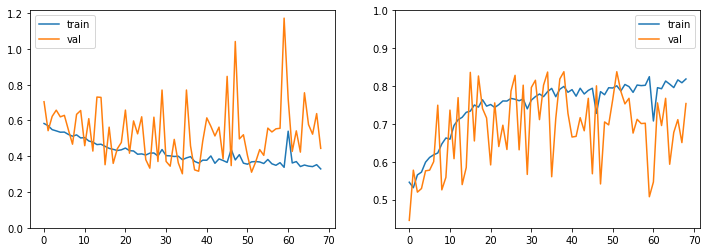

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5853 - accuracy: 0.6529 - precision: 0.8998 - recall: 0.6252 - f1: 0.7297 - specificity: 0.7476 - negative_predictive_value: 0.3550 - matthews_correlation_coefficient: 0.3125 - val_loss: 0.6740 - val_accuracy: 0.6297 - val_precision: 0.9124 - val_recall: 0.6036 - val_f1: 0.7214 - val_specificity: 0.7523 - val_negative_predictive_value: 0.3271 - val_matthews_correlation_coefficient: 0.2906

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29057, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_28-02_43_01.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5722 - accuracy: 0.6946 - precision: 0.8998 - recall: 0.6905 - f1: 0.7756 - specificity: 0.7062 - negative_predictive_value: 0.3851 - matthews_correlation_coefficient: 0.3348 - val_loss: 0.5860 - val_accuracy: 0.6522 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5312 - accuracy: 0.7017 - precision: 0.9168 - recall: 0.6847 - f1: 0.7783 - specificity: 0.7685 - negative_predictive_value: 0.4020 - matthews_correlation_coefficient: 0.3780 - val_loss: 0.6182 - val_accuracy: 0.6583 - val_precision: 0.9261 - val_recall: 0.6319 - val_f1: 0.7463 - val_specificity: 0.7767 - val_negative_predictive_value: 0.3522 - val_matthews_correlation_coefficient: 0.3355

Epoch 00015: val_matthews_correlation_coefficient improved from 0.32358 to 0.33549, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_28-02_43_01.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5224 - accuracy: 0.7161 - precision: 0.9192 - recall: 0.7026 - f1: 0.7909 - specificity: 0.7698 - negative_predictive_value: 0.4135 - matthews_correlation_coefficient: 0.3942 - val_loss: 0.6548 - val_accuracy: 0.6583 - val_precision: 0.8967 - val_recall: 0.6604 - val_f1: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5057 - accuracy: 0.7230 - precision: 0.9234 - recall: 0.7101 - f1: 0.7950 - specificity: 0.7668 - negative_predictive_value: 0.4289 - matthews_correlation_coefficient: 0.4077 - val_loss: 0.6237 - val_accuracy: 0.6366 - val_precision: 0.9485 - val_recall: 0.5844 - val_f1: 0.7181 - val_specificity: 0.8536 - val_negative_predictive_value: 0.3445 - val_matthews_correlation_coefficient: 0.3565

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37617
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4973 - accuracy: 0.7297 - precision: 0.9148 - recall: 0.7176 - f1: 0.7979 - specificity: 0.7606 - negative_predictive_value: 0.4289 - matthews_correlation_coefficient: 0.4086 - val_loss: 0.6012 - val_accuracy: 0.6522 - val_precision: 0.9395 - val_recall: 0.6118 - val_f1: 0.7361 - val_specificity: 0.8176 - val_negative_predictive_value: 0.3488 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.39933
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4849 - accuracy: 0.7319 - precision: 0.9314 - recall: 0.7183 - f1: 0.8023 - specificity: 0.7974 - negative_predictive_value: 0.4519 - matthews_correlation_coefficient: 0.4405 - val_loss: 0.5624 - val_accuracy: 0.6739 - val_precision: 0.9402 - val_recall: 0.6394 - val_f1: 0.7559 - val_specificity: 0.8243 - val_negative_predictive_value: 0.3722 - val_matthews_correlation_coefficient: 0.3788

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39933
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4736 - accuracy: 0.7484 - precision: 0.9225 - recall: 0.7360 - f1: 0.8127 - specificity: 0.7753 - negative_predictive_value: 0.4504 - matthews_correlation_coefficient: 0.4399 - val_loss: 0.5745 - val_accuracy: 0.6878 - val_precision: 0.9321 - val_recall: 0.6656 - val_f1: 0.7715 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.39933
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4623 - accuracy: 0.7581 - precision: 0.9325 - recall: 0.7539 - f1: 0.8285 - specificity: 0.7877 - negative_predictive_value: 0.4669 - matthews_correlation_coefficient: 0.4607 - val_loss: 0.6049 - val_accuracy: 0.6565 - val_precision: 0.9407 - val_recall: 0.6165 - val_f1: 0.7374 - val_specificity: 0.8279 - val_negative_predictive_value: 0.3604 - val_matthews_correlation_coefficient: 0.3641

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.39933
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4647 - accuracy: 0.7590 - precision: 0.9283 - recall: 0.7583 - f1: 0.8292 - specificity: 0.7783 - negative_predictive_value: 0.4723 - matthews_correlation_coefficient: 0.4587 - val_loss: 0.6485 - val_accuracy: 0.6487 - val_precision: 0.9452 - val_recall: 0.6058 - val_f1: 0.7322 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.42355
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4685 - accuracy: 0.7644 - precision: 0.9262 - recall: 0.7584 - f1: 0.8249 - specificity: 0.7762 - negative_predictive_value: 0.4916 - matthews_correlation_coefficient: 0.4734 - val_loss: 0.5050 - val_accuracy: 0.7407 - val_precision: 0.9219 - val_recall: 0.7456 - val_f1: 0.8207 - val_specificity: 0.7380 - val_negative_predictive_value: 0.4264 - val_matthews_correlation_coefficient: 0.4083

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.42355
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4472 - accuracy: 0.7744 - precision: 0.9343 - recall: 0.7727 - f1: 0.8399 - specificity: 0.7820 - negative_predictive_value: 0.4938 - matthews_correlation_coefficient: 0.4818 - val_loss: 0.6565 - val_accuracy: 0.6592 - val_precision: 0.9438 - val_recall: 0.6196 - val_f1: 0.7418 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.42355
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4401 - accuracy: 0.7852 - precision: 0.9362 - recall: 0.7842 - f1: 0.8469 - specificity: 0.7977 - negative_predictive_value: 0.5030 - matthews_correlation_coefficient: 0.5041 - val_loss: 0.5063 - val_accuracy: 0.7311 - val_precision: 0.9270 - val_recall: 0.7268 - val_f1: 0.8113 - val_specificity: 0.7611 - val_negative_predictive_value: 0.4169 - val_matthews_correlation_coefficient: 0.4074

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.42355
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4450 - accuracy: 0.7705 - precision: 0.9295 - recall: 0.7592 - f1: 0.8295 - specificity: 0.8006 - negative_predictive_value: 0.4849 - matthews_correlation_coefficient: 0.4828 - val_loss: 0.5135 - val_accuracy: 0.7042 - val_precision: 0.9265 - val_recall: 0.6929 - val_f1: 0.7885 - val_spe

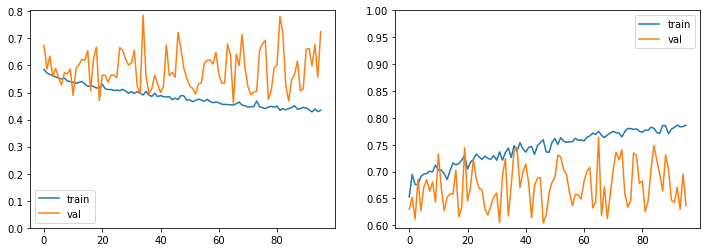

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5911 - accuracy: 0.7879 - precision: 0.9987 - recall: 0.7900 - f1: 0.8731 - specificity: 0.0621 - negative_predictive_value: 0.0067 - matthews_correlation_coefficient: 0.0169 - val_loss: 0.1556 - val_accuracy: 0.9670 - val_precision: 0.9983 - val_recall: 0.9695 - val_f1: 0.9833 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0270 - val_matthews_correlation_coefficient: 0.0367

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.03673, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_28-02_57_26.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4883 - accuracy: 0.7336 - precision: 0.9989 - recall: 0.7358 - f1: 0.8349 - specificity: 0.0690 - negative_predictive_value: 0.0091 - matthews_correlation_coefficient: 0.0201 - val_loss: 0.1757 - val_accuracy: 0.9332 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1847 - accuracy: 0.8866 - precision: 1.0000 - recall: 0.8870 - f1: 0.9386 - specificity: 0.0897 - negative_predictive_value: 0.0359 - matthews_correlation_coefficient: 0.0514 - val_loss: 0.2155 - val_accuracy: 0.9020 - val_precision: 1.0000 - val_recall: 0.9043 - val_f1: 0.9488 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0414 - val_matthews_correlation_coefficient: 0.0640

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.07972
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1414 - accuracy: 0.9187 - precision: 1.0000 - recall: 0.9189 - f1: 0.9569 - specificity: 0.1034 - negative_predictive_value: 0.0365 - matthews_correlation_coefficient: 0.0571 - val_loss: 0.1910 - val_accuracy: 0.9228 - val_precision: 1.0000 - val_recall: 0.9247 - val_f1: 0.9602 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0473 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.09617
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1654 - accuracy: 0.9013 - precision: 1.0000 - recall: 0.9017 - f1: 0.9469 - specificity: 0.0966 - negative_predictive_value: 0.0336 - matthews_correlation_coefficient: 0.0542 - val_loss: 0.1913 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.9187 - val_f1: 0.9568 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0428 - val_matthews_correlation_coefficient: 0.0655

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.09617
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1305 - accuracy: 0.9252 - precision: 1.0000 - recall: 0.9254 - f1: 0.9606 - specificity: 0.0966 - negative_predictive_value: 0.0402 - matthews_correlation_coefficient: 0.0575 - val_loss: 0.0624 - val_accuracy: 0.9696 - val_precision: 1.0000 - val_recall: 0.9704 - val_f1: 0.9847 - val_spe


Epoch 00044: val_matthews_correlation_coefficient improved from 0.09617 to 0.09988, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_28-02_57_26.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1054 - accuracy: 0.9408 - precision: 1.0000 - recall: 0.9410 - f1: 0.9689 - specificity: 0.1034 - negative_predictive_value: 0.0632 - matthews_correlation_coefficient: 0.0761 - val_loss: 0.0632 - val_accuracy: 0.9731 - val_precision: 1.0000 - val_recall: 0.9738 - val_f1: 0.9865 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0946 - val_matthews_correlation_coefficient: 0.0999

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0870 - accuracy: 0.9566 - precision: 1.0000 - recall: 0.9568 - f1: 0.9774 - specificity: 0.0966 - negative_predictive_value: 0.0592 - matthews_correlation_coefficient: 0.0721 - val_loss: 0.14


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1048 - accuracy: 0.9453 - precision: 1.0000 - recall: 0.9455 - f1: 0.9715 - specificity: 0.1034 - negative_predictive_value: 0.0474 - matthews_correlation_coefficient: 0.0674 - val_loss: 0.0980 - val_accuracy: 0.9627 - val_precision: 1.0000 - val_recall: 0.9636 - val_f1: 0.9811 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0901 - val_matthews_correlation_coefficient: 0.0962

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0549 - accuracy: 0.9672 - precision: 1.0000 - recall: 0.9674 - f1: 0.9832 - specificity: 0.1034 - negative_predictive_value: 0.0730 - matthews_correlation_coefficient: 0.0842 - val_loss: 0.0567 - val_accuracy: 0.9783 - val_precision: 1.0000 - val_recall: 0.9789 - val_f1: 0.9891 - val_spe

Restoring model weights from the end of the best epoch

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 00074: early stopping

   Final Accuracy:  98.35%
  Final Precision: 100.00%
     Final Recall:  98.35%
  Final F-measure:  99.17%
Final Specificity: 100.00%
        Final NPV:  17.39%
        Final MCC:  41.36%
[[   4    0]
 [  19 1130]]
              precision    recall  f1-score   support

           0       0.17      1.00      0.30         4
           1       1.00      0.98      0.99      1149

    accuracy                           0.98      1153
   macro avg       0.59      0.99      0.64      1153
weighted avg       1.00      0.98      0.99      1153



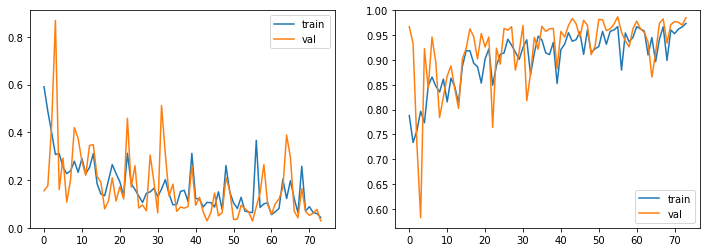

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6010 - accuracy: 0.6443 - precision: 0.8730 - recall: 0.6018 - f1: 0.6942 - specificity: 0.7481 - negative_predictive_value: 0.4289 - matthews_correlation_coefficient: 0.3256 - val_loss: 0.5742 - val_accuracy: 0.6739 - val_precision: 0.8575 - val_recall: 0.6582 - val_f1: 0.7413 - val_specificity: 0.7116 - val_negative_predictive_value: 0.4409 - val_matthews_correlation_coefficient: 0.3315

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.33146, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_28-03_08_39.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5831 - accuracy: 0.6610 - precision: 0.8906 - recall: 0.6072 - f1: 0.7134 - specificity: 0.7954 - negative_predictive_value: 0.4445 - matthews_correlation_coefficient: 0.3677 - val_loss: 0.5840 - val_accuracy: 0.6765 - val_p


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.41344
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5562 - accuracy: 0.6837 - precision: 0.9005 - recall: 0.6380 - f1: 0.7384 - specificity: 0.8074 - negative_predictive_value: 0.4671 - matthews_correlation_coefficient: 0.4027 - val_loss: 0.5141 - val_accuracy: 0.6982 - val_precision: 0.8538 - val_recall: 0.7069 - val_f1: 0.7699 - val_specificity: 0.6790 - val_negative_predictive_value: 0.4667 - val_matthews_correlation_coefficient: 0.3509

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.41344
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5535 - accuracy: 0.6913 - precision: 0.9015 - recall: 0.6490 - f1: 0.7451 - specificity: 0.8007 - negative_predictive_value: 0.4767 - matthews_correlation_coefficient: 0.4124 - val_loss: 0.5446 - val_accuracy: 0.6930 - val_precision: 0.8786 - val_recall: 0.6705 - val_f1: 0.7564 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.42145
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5235 - accuracy: 0.7052 - precision: 0.9054 - recall: 0.6528 - f1: 0.7521 - specificity: 0.8289 - negative_predictive_value: 0.4896 - matthews_correlation_coefficient: 0.4412 - val_loss: 0.5228 - val_accuracy: 0.7034 - val_precision: 0.8506 - val_recall: 0.7156 - val_f1: 0.7733 - val_specificity: 0.6614 - val_negative_predictive_value: 0.4722 - val_matthews_correlation_coefficient: 0.3482

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.42145
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5219 - accuracy: 0.7111 - precision: 0.9091 - recall: 0.6693 - f1: 0.7650 - specificity: 0.8137 - negative_predictive_value: 0.4918 - matthews_correlation_coefficient: 0.4402 - val_loss: 0.5940 - val_accuracy: 0.6713 - val_precision: 0.9192 - val_recall: 0.6025 - val_f1: 0.7215 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5081 - accuracy: 0.7169 - precision: 0.9071 - recall: 0.6756 - f1: 0.7677 - specificity: 0.8243 - negative_predictive_value: 0.4975 - matthews_correlation_coefficient: 0.4500 - val_loss: 0.5316 - val_accuracy: 0.7077 - val_precision: 0.8984 - val_recall: 0.6737 - val_f1: 0.7658 - val_specificity: 0.7847 - val_negative_predictive_value: 0.4762 - val_matthews_correlation_coefficient: 0.4134

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.42145
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5080 - accuracy: 0.7208 - precision: 0.9151 - recall: 0.6758 - f1: 0.7711 - specificity: 0.8297 - negative_predictive_value: 0.5054 - matthews_correlation_coefficient: 0.4609 - val_loss: 0.5573 - val_accuracy: 0.7077 - val_precision: 0.9161 - val_recall: 0.6559 - val_f1: 0.7590 - val_specificity: 0.8264 - val_negative_predictive_value: 0.4773 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.43590
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4918 - accuracy: 0.7315 - precision: 0.9213 - recall: 0.6901 - f1: 0.7827 - specificity: 0.8387 - negative_predictive_value: 0.5158 - matthews_correlation_coefficient: 0.4792 - val_loss: 0.4978 - val_accuracy: 0.7311 - val_precision: 0.8469 - val_recall: 0.7704 - val_f1: 0.8033 - val_specificity: 0.6161 - val_negative_predictive_value: 0.5051 - val_matthews_correlation_coefficient: 0.3678

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.43590
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4902 - accuracy: 0.7351 - precision: 0.9195 - recall: 0.6954 - f1: 0.7862 - specificity: 0.8481 - negative_predictive_value: 0.5244 - matthews_correlation_coefficient: 0.4887 - val_loss: 0.5214 - val_accuracy: 0.6999 - val_precision: 0.8523 - val_recall: 0.7087 - val_f1: 0.7699 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.43590
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4838 - accuracy: 0.7271 - precision: 0.9172 - recall: 0.6826 - f1: 0.7772 - specificity: 0.8472 - negative_predictive_value: 0.5070 - matthews_correlation_coefficient: 0.4742 - val_loss: 0.5114 - val_accuracy: 0.7216 - val_precision: 0.8728 - val_recall: 0.7232 - val_f1: 0.7850 - val_specificity: 0.6999 - val_negative_predictive_value: 0.4926 - val_matthews_correlation_coefficient: 0.3924

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.43590
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4852 - accuracy: 0.7325 - precision: 0.9262 - recall: 0.6861 - f1: 0.7830 - specificity: 0.8584 - negative_predictive_value: 0.5214 - matthews_correlation_coefficient: 0.4920 - val_loss: 0.5177 - val_accuracy: 0.7164 - val_precision: 0.8612 - val_recall: 0.7284 - val_f1: 0.7855 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.44295
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4769 - accuracy: 0.7423 - precision: 0.9230 - recall: 0.7008 - f1: 0.7909 - specificity: 0.8445 - negative_predictive_value: 0.5291 - matthews_correlation_coefficient: 0.4963 - val_loss: 0.5764 - val_accuracy: 0.6878 - val_precision: 0.9259 - val_recall: 0.6200 - val_f1: 0.7365 - val_specificity: 0.8495 - val_negative_predictive_value: 0.4582 - val_matthews_correlation_coefficient: 0.4233

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.44295
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4755 - accuracy: 0.7419 - precision: 0.9181 - recall: 0.7060 - f1: 0.7911 - specificity: 0.8375 - negative_predictive_value: 0.5274 - matthews_correlation_coefficient: 0.4896 - val_loss: 0.5483 - val_accuracy: 0.7225 - val_precision: 0.9090 - val_recall: 0.6831 - val_f1: 0.7762 - val_spe

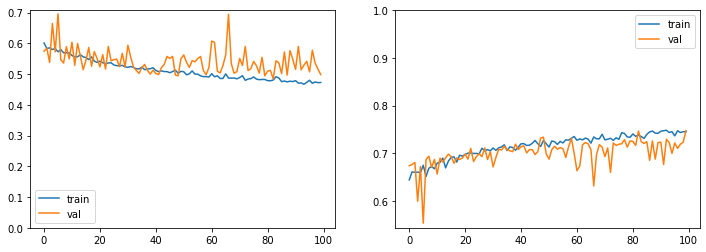

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6065 - accuracy: 0.6085 - precision: 0.9302 - recall: 0.5917 - f1: 0.7057 - specificity: 0.7130 - negative_predictive_value: 0.2241 - matthews_correlation_coefficient: 0.2180 - val_loss: 0.5594 - val_accuracy: 0.6193 - val_precision: 0.9209 - val_recall: 0.5723 - val_f1: 0.7015 - val_specificity: 0.8205 - val_negative_predictive_value: 0.2745 - val_matthews_correlation_coefficient: 0.2708

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27083, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_28-03_23_46.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5521 - accuracy: 0.6343 - precision: 0.9473 - recall: 0.6082 - f1: 0.7343 - specificity: 0.7659 - negative_predictive_value: 0.2584 - matthews_correlation_coefficient: 0.2757 - val_loss: 0.6862 - val_accuracy: 0.5152 - val_precision: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4774 - accuracy: 0.7193 - precision: 0.9570 - recall: 0.7057 - f1: 0.8070 - specificity: 0.7925 - negative_predictive_value: 0.3224 - matthews_correlation_coefficient: 0.3698 - val_loss: 0.4896 - val_accuracy: 0.7233 - val_precision: 0.9050 - val_recall: 0.7097 - val_f1: 0.7923 - val_specificity: 0.7082 - val_negative_predictive_value: 0.3414 - val_matthews_correlation_coefficient: 0.3147

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36273
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4812 - accuracy: 0.7171 - precision: 0.9490 - recall: 0.7115 - f1: 0.8055 - specificity: 0.7751 - negative_predictive_value: 0.3229 - matthews_correlation_coefficient: 0.3552 - val_loss: 0.5056 - val_accuracy: 0.7173 - val_precision: 0.9204 - val_recall: 0.6885 - val_f1: 0.7843 - val_specificity: 0.7861 - val_negative_predictive_value: 0.3464 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37519
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4233 - accuracy: 0.7584 - precision: 0.9609 - recall: 0.7496 - f1: 0.8376 - specificity: 0.8138 - negative_predictive_value: 0.3681 - matthews_correlation_coefficient: 0.4241 - val_loss: 0.4569 - val_accuracy: 0.7372 - val_precision: 0.9265 - val_recall: 0.7082 - val_f1: 0.7991 - val_specificity: 0.8060 - val_negative_predictive_value: 0.3678 - val_matthews_correlation_coefficient: 0.3825

Epoch 00030: val_matthews_correlation_coefficient improved from 0.37519 to 0.38247, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_28-03_23_46.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4341 - accuracy: 0.7512 - precision: 0.9570 - recall: 0.7440 - f1: 0.8301 - specificity: 0.7956 - negative_predictive_value: 0.3665 - matthews_correlation_coefficient: 0.4164 - val_loss: 0.5473 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4123 - accuracy: 0.7670 - precision: 0.9675 - recall: 0.7541 - f1: 0.8425 - specificity: 0.8366 - negative_predictive_value: 0.3880 - matthews_correlation_coefficient: 0.4529 - val_loss: 0.4205 - val_accuracy: 0.7693 - val_precision: 0.9081 - val_recall: 0.7629 - val_f1: 0.8260 - val_specificity: 0.6983 - val_negative_predictive_value: 0.4032 - val_matthews_correlation_coefficient: 0.3719

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.42125
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4029 - accuracy: 0.7861 - precision: 0.9627 - recall: 0.7792 - f1: 0.8560 - specificity: 0.8391 - negative_predictive_value: 0.4075 - matthews_correlation_coefficient: 0.4722 - val_loss: 0.4244 - val_accuracy: 0.7658 - val_precision: 0.9162 - val_recall: 0.7511 - val_f1: 0.8225 - val_specificity: 0.7499 - val_negative_predictive_value: 0.3997 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.44727
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4123 - accuracy: 0.7748 - precision: 0.9678 - recall: 0.7662 - f1: 0.8493 - specificity: 0.8399 - negative_predictive_value: 0.3924 - matthews_correlation_coefficient: 0.4581 - val_loss: 0.3373 - val_accuracy: 0.8309 - val_precision: 0.8877 - val_recall: 0.8647 - val_f1: 0.8748 - val_specificity: 0.4549 - val_negative_predictive_value: 0.4204 - val_matthews_correlation_coefficient: 0.3348

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.44727
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3869 - accuracy: 0.7946 - precision: 0.9655 - recall: 0.7914 - f1: 0.8646 - specificity: 0.8250 - negative_predictive_value: 0.4231 - matthews_correlation_coefficient: 0.4810 - val_loss: 0.3109 - val_accuracy: 0.8595 - val_precision: 0.8873 - val_recall: 0.9000 - val_f1: 0.8927 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46644
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3672 - accuracy: 0.8067 - precision: 0.9678 - recall: 0.7995 - f1: 0.8719 - specificity: 0.8593 - negative_predictive_value: 0.4226 - matthews_correlation_coefficient: 0.5018 - val_loss: 0.3473 - val_accuracy: 0.8222 - val_precision: 0.9071 - val_recall: 0.8296 - val_f1: 0.8650 - val_specificity: 0.6463 - val_negative_predictive_value: 0.4659 - val_matthews_correlation_coefficient: 0.4146

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.46644
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4179 - accuracy: 0.7868 - precision: 0.9613 - recall: 0.7850 - f1: 0.8597 - specificity: 0.8145 - negative_predictive_value: 0.4053 - matthews_correlation_coefficient: 0.4602 - val_loss: 0.3752 - val_accuracy: 0.8127 - val_precision: 0.9051 - val_recall: 0.8204 - val_f1: 0.8588 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3754 - accuracy: 0.8043 - precision: 0.9673 - recall: 0.8011 - f1: 0.8719 - specificity: 0.8195 - negative_predictive_value: 0.4262 - matthews_correlation_coefficient: 0.4861 - val_loss: 0.3024 - val_accuracy: 0.8690 - val_precision: 0.9068 - val_recall: 0.8885 - val_f1: 0.8964 - val_specificity: 0.6155 - val_negative_predictive_value: 0.5723 - val_matthews_correlation_coefficient: 0.4831

Epoch 00088: val_matthews_correlation_coefficient improved from 0.47356 to 0.48307, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_28-03_23_46.h5
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3589 - accuracy: 0.8052 - precision: 0.9670 - recall: 0.8005 - f1: 0.8706 - specificity: 0.8503 - negative_predictive_value: 0.4336 - matthews_correlation_coefficient: 0.5036 - val_loss: 0.3726 - val_accuracy: 0.8144 - val_precision: 0.9299 - val_recall: 0.7979 - val_f1: 0.8567 - val_specific

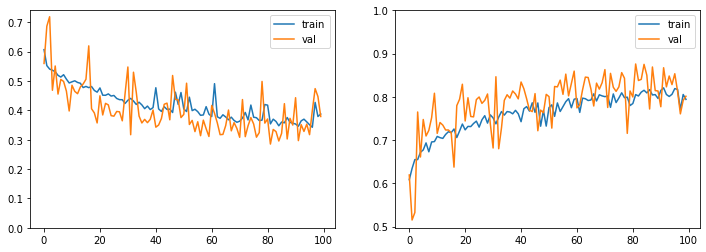

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4151 - accuracy: 0.7818 - precision: 0.9921 - recall: 0.7720 - f1: 0.8622 - specificity: 0.8027 - negative_predictive_value: 0.2278 - matthews_correlation_coefficient: 0.3544 - val_loss: 0.3807 - val_accuracy: 0.8387 - val_precision: 0.9643 - val_recall: 0.8136 - val_f1: 0.8811 - val_specificity: 0.7748 - val_negative_predictive_value: 0.2588 - val_matthews_correlation_coefficient: 0.3829

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38286, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_28-03_38_52.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3224 - accuracy: 0.8698 - precision: 0.9917 - recall: 0.8666 - f1: 0.9230 - specificity: 0.7196 - negative_predictive_value: 0.3117 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.4039 - val_accuracy: 0.8491 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2419 - accuracy: 0.9158 - precision: 0.9932 - recall: 0.9173 - f1: 0.9524 - specificity: 0.8023 - negative_predictive_value: 0.4604 - matthews_correlation_coefficient: 0.5620 - val_loss: 0.1886 - val_accuracy: 0.9376 - val_precision: 0.9635 - val_recall: 0.9180 - val_f1: 0.9398 - val_specificity: 0.7477 - val_negative_predictive_value: 0.4450 - val_matthews_correlation_coefficient: 0.5381

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2488 - accuracy: 0.9197 - precision: 0.9918 - recall: 0.9224 - f1: 0.9549 - specificity: 0.7823 - negative_predictive_value: 0.4400 - matthews_correlation_coefficient: 0.5401 - val_loss: 0.2038 - val_accuracy: 0.9384 - val_precision: 0.9635 - val_recall: 0.9189 - val_f1: 0.9402 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2005 - accuracy: 0.9386 - precision: 0.9939 - recall: 0.9377 - f1: 0.9638 - specificity: 0.7611 - negative_predictive_value: 0.5021 - matthews_correlation_coefficient: 0.5830 - val_loss: 0.1303 - val_accuracy: 0.9636 - val_precision: 0.9908 - val_recall: 0.9710 - val_f1: 0.9805 - val_specificity: 0.7658 - val_negative_predictive_value: 0.5948 - val_matthews_correlation_coefficient: 0.6447

Epoch 00029: val_matthews_correlation_coefficient improved from 0.59848 to 0.64469, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_28-03_38_52.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2301 - accuracy: 0.9278 - precision: 0.9891 - recall: 0.9306 - f1: 0.9568 - specificity: 0.7816 - negative_predictive_value: 0.4989 - matthews_correlation_coefficient: 0.5805 - val_loss: 0.3644 - val_accuracy: 0.8942 - val_precision: 0.9669 - val_recall: 0.8696 - val_f1: 0.9149 - val_s


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.64469
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1746 - accuracy: 0.9403 - precision: 0.9942 - recall: 0.9425 - f1: 0.9666 - specificity: 0.7902 - negative_predictive_value: 0.5440 - matthews_correlation_coefficient: 0.6154 - val_loss: 0.1422 - val_accuracy: 0.9575 - val_precision: 0.9673 - val_recall: 0.9352 - val_f1: 0.9506 - val_specificity: 0.8063 - val_negative_predictive_value: 0.6011 - val_matthews_correlation_coefficient: 0.6642

Epoch 00044: val_matthews_correlation_coefficient improved from 0.64469 to 0.66424, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_28-03_38_52.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1627 - accuracy: 0.9538 - precision: 0.9942 - recall: 0.9566 - f1: 0.9745 - specificity: 0.8156 - negative_predictive_value: 0.5999 - matthews_correlation_coefficient: 0.6658 - val_loss: 0.2724

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1434 - accuracy: 0.9544 - precision: 0.9951 - recall: 0.9569 - f1: 0.9749 - specificity: 0.7929 - negative_predictive_value: 0.6069 - matthews_correlation_coefficient: 0.6603 - val_loss: 0.3438 - val_accuracy: 0.8907 - val_precision: 0.9700 - val_recall: 0.8630 - val_f1: 0.9128 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3313 - val_matthews_correlation_coefficient: 0.4800

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1640 - accuracy: 0.9471 - precision: 0.9953 - recall: 0.9483 - f1: 0.9700 - specificity: 0.8495 - negative_predictive_value: 0.5979 - matthews_correlation_coefficient: 0.6767 - val_loss: 0.4156 - val_accuracy: 0.8716 - val_precision: 0.9688 - val_recall: 0.8444 - val_f1: 0.9017 - val_specificity: 0.8266 - val_negative_predictive_value: 0.2989 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1380 - accuracy: 0.9555 - precision: 0.9955 - recall: 0.9576 - f1: 0.9757 - specificity: 0.8283 - negative_predictive_value: 0.5924 - matthews_correlation_coefficient: 0.6659 - val_loss: 0.2782 - val_accuracy: 0.8699 - val_precision: 0.9698 - val_recall: 0.8411 - val_f1: 0.9001 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3008 - val_matthews_correlation_coefficient: 0.4507

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1275 - accuracy: 0.9586 - precision: 0.9964 - recall: 0.9596 - f1: 0.9771 - specificity: 0.8432 - negative_predictive_value: 0.6287 - matthews_correlation_coefficient: 0.6968 - val_loss: 0.1736 - val_accuracy: 0.9228 - val_precision: 0.9959 - val_recall: 0.9228 - val_f1: 0.9576 - val_specificity: 0.8279 - val_negative_predictive_value: 0.4162 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 00087: early stopping

   Final Accuracy:  98.01%
  Final Precision:  99.35%
     Final Recall:  98.52%
  Final F-measure:  98.93%
Final Specificity:  90.41%
        Final NPV:  80.49%
        Final MCC:  84.26%
[[  66    7]
 [  16 1064]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        73
           1       0.99      0.99      0.99      1080

    accuracy                           0.98      1153
   macro avg       0.90      0.94      0.92      1153
weighted avg       0.98      0.98      0.98      1153



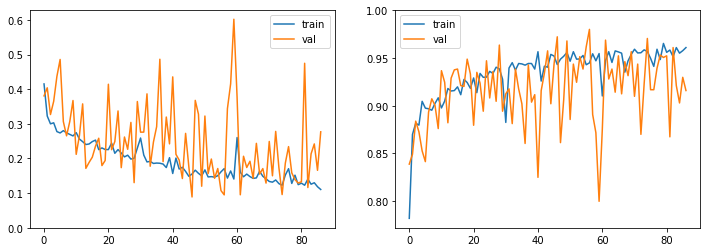

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6096 - accuracy: 0.6549 - precision: 0.8755 - recall: 0.6235 - f1: 0.7183 - specificity: 0.7453 - negative_predictive_value: 0.4103 - matthews_correlation_coefficient: 0.3284 - val_loss: 0.5972 - val_accuracy: 0.6271 - val_precision: 0.8521 - val_recall: 0.5566 - val_f1: 0.6690 - val_specificity: 0.7846 - val_negative_predictive_value: 0.4179 - val_matthews_correlation_coefficient: 0.3021

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30206, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_28-03_52_01.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5858 - accuracy: 0.6646 - precision: 0.8754 - recall: 0.6272 - f1: 0.7235 - specificity: 0.7667 - negative_predictive_value: 0.4334 - matthews_correlation_coefficient: 0.3465 - val_loss: 0.6210 - val_accuracy: 0.6297 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5498 - accuracy: 0.6959 - precision: 0.8867 - recall: 0.6742 - f1: 0.7595 - specificity: 0.7663 - negative_predictive_value: 0.4714 - matthews_correlation_coefficient: 0.3948 - val_loss: 0.6630 - val_accuracy: 0.6340 - val_precision: 0.8720 - val_recall: 0.5495 - val_f1: 0.6694 - val_specificity: 0.8297 - val_negative_predictive_value: 0.4284 - val_matthews_correlation_coefficient: 0.3358

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36225
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5505 - accuracy: 0.6900 - precision: 0.8858 - recall: 0.6613 - f1: 0.7515 - specificity: 0.7683 - negative_predictive_value: 0.4570 - matthews_correlation_coefficient: 0.3835 - val_loss: 0.5804 - val_accuracy: 0.6687 - val_precision: 0.8621 - val_recall: 0.6109 - val_f1: 0.7115 - val_specificity: 0.7920 - val_negative_predictive_value: 0.4522 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37265
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5346 - accuracy: 0.7156 - precision: 0.8882 - recall: 0.7002 - f1: 0.7773 - specificity: 0.7590 - negative_predictive_value: 0.4844 - matthews_correlation_coefficient: 0.4132 - val_loss: 0.5967 - val_accuracy: 0.6583 - val_precision: 0.8664 - val_recall: 0.5896 - val_f1: 0.6975 - val_specificity: 0.8118 - val_negative_predictive_value: 0.4464 - val_matthews_correlation_coefficient: 0.3525

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.37265
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5297 - accuracy: 0.7067 - precision: 0.8876 - recall: 0.6752 - f1: 0.7618 - specificity: 0.7867 - negative_predictive_value: 0.4796 - matthews_correlation_coefficient: 0.4122 - val_loss: 0.5481 - val_accuracy: 0.6990 - val_precision: 0.8519 - val_recall: 0.6700 - val_f1: 0.7469 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.38098
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5222 - accuracy: 0.7200 - precision: 0.8992 - recall: 0.6966 - f1: 0.7799 - specificity: 0.7733 - negative_predictive_value: 0.4856 - matthews_correlation_coefficient: 0.4250 - val_loss: 0.4997 - val_accuracy: 0.7285 - val_precision: 0.8277 - val_recall: 0.7436 - val_f1: 0.7805 - val_specificity: 0.6346 - val_negative_predictive_value: 0.5061 - val_matthews_correlation_coefficient: 0.3541

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.38098
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5239 - accuracy: 0.7247 - precision: 0.8900 - recall: 0.7158 - f1: 0.7876 - specificity: 0.7602 - negative_predictive_value: 0.5035 - matthews_correlation_coefficient: 0.4305 - val_loss: 0.5890 - val_accuracy: 0.6904 - val_precision: 0.8467 - val_recall: 0.6589 - val_f1: 0.7378 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.38098
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5133 - accuracy: 0.7161 - precision: 0.9060 - recall: 0.6822 - f1: 0.7718 - specificity: 0.8034 - negative_predictive_value: 0.4862 - matthews_correlation_coefficient: 0.4357 - val_loss: 0.5867 - val_accuracy: 0.7025 - val_precision: 0.8396 - val_recall: 0.6877 - val_f1: 0.7526 - val_specificity: 0.6988 - val_negative_predictive_value: 0.4793 - val_matthews_correlation_coefficient: 0.3498

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.38098
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5199 - accuracy: 0.7245 - precision: 0.8920 - recall: 0.7090 - f1: 0.7841 - specificity: 0.7586 - negative_predictive_value: 0.4973 - matthews_correlation_coefficient: 0.4260 - val_loss: 0.5277 - val_accuracy: 0.7069 - val_precision: 0.8482 - val_recall: 0.6860 - val_f1: 0.7554 - val_spe

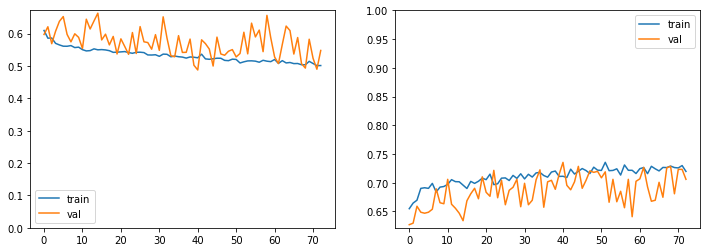

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4711 - accuracy: 0.8108 - precision: 0.9985 - recall: 0.8125 - f1: 0.8903 - specificity: 0.1379 - negative_predictive_value: 0.0216 - matthews_correlation_coefficient: 0.0477 - val_loss: 0.2659 - val_accuracy: 0.8621 - val_precision: 1.0000 - val_recall: 0.8648 - val_f1: 0.9260 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0397 - val_matthews_correlation_coefficient: 0.0777

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.07768, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_28-04_03_10.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2685 - accuracy: 0.8345 - precision: 1.0000 - recall: 0.8347 - f1: 0.9076 - specificity: 0.1862 - negative_predictive_value: 0.0495 - matthews_correlation_coefficient: 0.0856 - val_loss: 0.1702 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1756 - accuracy: 0.8963 - precision: 1.0000 - recall: 0.8964 - f1: 0.9447 - specificity: 0.1862 - negative_predictive_value: 0.0621 - matthews_correlation_coefficient: 0.0999 - val_loss: 0.2701 - val_accuracy: 0.8985 - val_precision: 1.0000 - val_recall: 0.9005 - val_f1: 0.9466 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0633 - val_matthews_correlation_coefficient: 0.0979

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.09787
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1992 - accuracy: 0.8803 - precision: 0.9998 - recall: 0.8772 - f1: 0.9333 - specificity: 0.1931 - negative_predictive_value: 0.0499 - matthews_correlation_coefficient: 0.0887 - val_loss: 0.2472 - val_accuracy: 0.8942 - val_precision: 1.0000 - val_recall: 0.8963 - val_f1: 0.9443 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0620 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.09881
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1809 - accuracy: 0.8894 - precision: 0.9998 - recall: 0.8864 - f1: 0.9384 - specificity: 0.1862 - negative_predictive_value: 0.0478 - matthews_correlation_coefficient: 0.0872 - val_loss: 0.2304 - val_accuracy: 0.8951 - val_precision: 1.0000 - val_recall: 0.8970 - val_f1: 0.9445 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0579 - val_matthews_correlation_coefficient: 0.0914

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.09881
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1691 - accuracy: 0.8967 - precision: 1.0000 - recall: 0.8969 - f1: 0.9450 - specificity: 0.1862 - negative_predictive_value: 0.0593 - matthews_correlation_coefficient: 0.0988 - val_loss: 0.1700 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.9183 - val_f1: 0.9564 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.09944
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1561 - accuracy: 0.9039 - precision: 1.0000 - recall: 0.9040 - f1: 0.9487 - specificity: 0.2000 - negative_predictive_value: 0.0759 - matthews_correlation_coefficient: 0.1119 - val_loss: 0.1622 - val_accuracy: 0.9219 - val_precision: 1.0000 - val_recall: 0.9234 - val_f1: 0.9594 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0698 - val_matthews_correlation_coefficient: 0.1041

Epoch 00045: val_matthews_correlation_coefficient improved from 0.09944 to 0.10408, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_28-04_03_10.h5
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1622 - accuracy: 0.9037 - precision: 1.0000 - recall: 0.9038 - f1: 0.9488 - specificity: 0.1724 - negative_predictive_value: 0.0555 - matthews_correlation_coefficient: 0.0908 -

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1499 - accuracy: 0.9100 - precision: 1.0000 - recall: 0.9100 - f1: 0.9523 - specificity: 0.1862 - negative_predictive_value: 0.0608 - matthews_correlation_coefficient: 0.0976 - val_loss: 0.2233 - val_accuracy: 0.9115 - val_precision: 1.0000 - val_recall: 0.9132 - val_f1: 0.9536 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0633 - val_matthews_correlation_coefficient: 0.0979

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.10525
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1544 - accuracy: 0.9082 - precision: 1.0000 - recall: 0.9084 - f1: 0.9514 - specificity: 0.1931 - negative_predictive_value: 0.0725 - matthews_correlation_coefficient: 0.1112 - val_loss: 0.2442 - val_accuracy: 0.8968 - val_precision: 1.0000 - val_recall: 0.8988 - val_f1: 0.9456 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0604 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1655 - accuracy: 0.9007 - precision: 1.0000 - recall: 0.9007 - f1: 0.9470 - specificity: 0.1862 - negative_predictive_value: 0.0562 - matthews_correlation_coefficient: 0.0955 - val_loss: 0.2233 - val_accuracy: 0.8933 - val_precision: 1.0000 - val_recall: 0.8953 - val_f1: 0.9436 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0579 - val_matthews_correlation_coefficient: 0.0914

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.10525
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1514 - accuracy: 0.9100 - precision: 1.0000 - recall: 0.9100 - f1: 0.9522 - specificity: 0.1793 - negative_predictive_value: 0.0666 - matthews_correlation_coefficient: 0.1008 - val_loss: 0.1775 - val_accuracy: 0.9289 - val_precision: 0.9990 - val_recall: 0.9311 - val_f1: 0.9632 - val_specificity: 0.1622 - val_negative_predictive_value: 0.0730 - val_matthews_correlation_coefficie

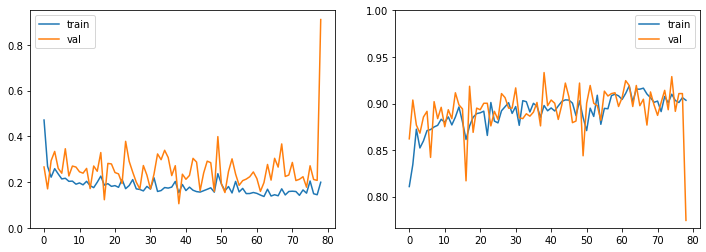

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_27-23_49_46.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_28-00_04_59.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_28-00_15_32.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_28-00_26_55.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_28-00_32_56.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_28-00_39_35.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_28-00_54_26.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_28-01_04_55.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_28-01_13_21.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_28-01_25_44.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_28-01_40_38.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_28-01_55_32.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_28-02_04_49.h5'


In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

# list_files = glob('../data/pybossa/images/*')
list_files = ['../data/pybossa/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.99999976]], dtype=float32),
 array([[0.70135814]], dtype=float32),
 array([[0.8318434]], dtype=float32),
 array([[0.9005545]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.88921857]], dtype=float32),
 array([[0.8880711]], dtype=float32),
 array([[0.42868015]], dtype=float32),
 array([[0.45189422]], dtype=float32),
 array([[0.78732145]], dtype=float32),
 array([[0.97370344]], dtype=float32),
 array([[0.65554523]], dtype=float32),
 array([[0.99997866]], dtype=float32),
 array([[0.9859335]], dtype=float32),
 array([[0.9549063]], dtype=float32),
 array([[0.18664272]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.726284]], dtype=float32),
 array([[0.9999969]], dtype=float32),
 array([[0.999801]], dtype=float32),
 array([[0.46980602]], dtype=float32),
 array([[1.]], dtype=float32)]